In [1]:
# import packages

import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import pickle
from dark_ub_functions import annotate_ions_for_plotting, return_mzs_to_shift, return_modified_frags, cosine_similarity, KDE_align
from dark_ub_functions import masses

In [2]:
# this script compares KGG peptides to unmodified tryptic peptides

In [3]:
# import data
pickled_path = 'pickled_data/dark_ub_data_dict.pkl'

try:
    with open(pickled_path, 'rb') as f:
        loaded_dict = pickle.load(f)
    print("Dictionary loaded successfully.")
except Exception as e:
    print(f"Failed to load dictionary: {e}")

Dictionary loaded successfully.


The structure of loaded_dict is as follows:

Top-Level Keys: 'trypsin' and 'LysC' represent different protease digestion methods done in Akimov et al. For this script, we only use the data from the trypsin experiments.

Sub-Level 1 Keys: 'Prosit' and 'experimental' represent the Prosit predicted libraries and the experimental data, respectively.

Sub-Level 2 Keys: 'modified' and 'unmodified' represent the modification status of precursors. In this case, modified means a KGG modification.

Sub-level 3 Keys: Different precursors in the structure ('PEPTIDE' : str, charge : int).

Sub-level 4 Keys: Attributes include:

    RT: Retention time in seconds (float).
    modseq: Modified sequence (str).
    mz_array: Array of mass-to-charge ratio values (np.array).
    intensity_array: Array of intensity values (np.array).
    summed_ion_intensity: Summed ion intensity (float).

In [4]:
# retention time comparison
# use shared peptides between mod and unmod


# Extract RT for unmodified and modified peptides
rt_obs = {precursor[0]: data['RT'] for precursor, data in loaded_dict['trypsin']['experimental']['unmodified'].items()}
rt_obs_KGG = {precursor[0]: data['RT'] for precursor, data in loaded_dict['trypsin']['experimental']['modified'].items()}

# Find shared peptides
shared_peptides = set(rt_obs.keys()) & set(rt_obs_KGG.keys())

# Create dictionaries of unmod RT and mod RT
rt_unmod = [rt_obs[x] for x in shared_peptides]
rt_mod = [rt_obs_KGG[x] for x in shared_peptides]
rt_dict = {rt_obs[x]: rt_obs_KGG[x] for x in shared_peptides}


    
# KDE align unmodified and modified peptides
spline, interpolation_range, density_array, fit_x, fit_y = KDE_align(rt_unmod, rt_mod)

# residual analysis KDE alignment
rt_diff = [rt_dict[rt] - rt for rt in rt_dict]

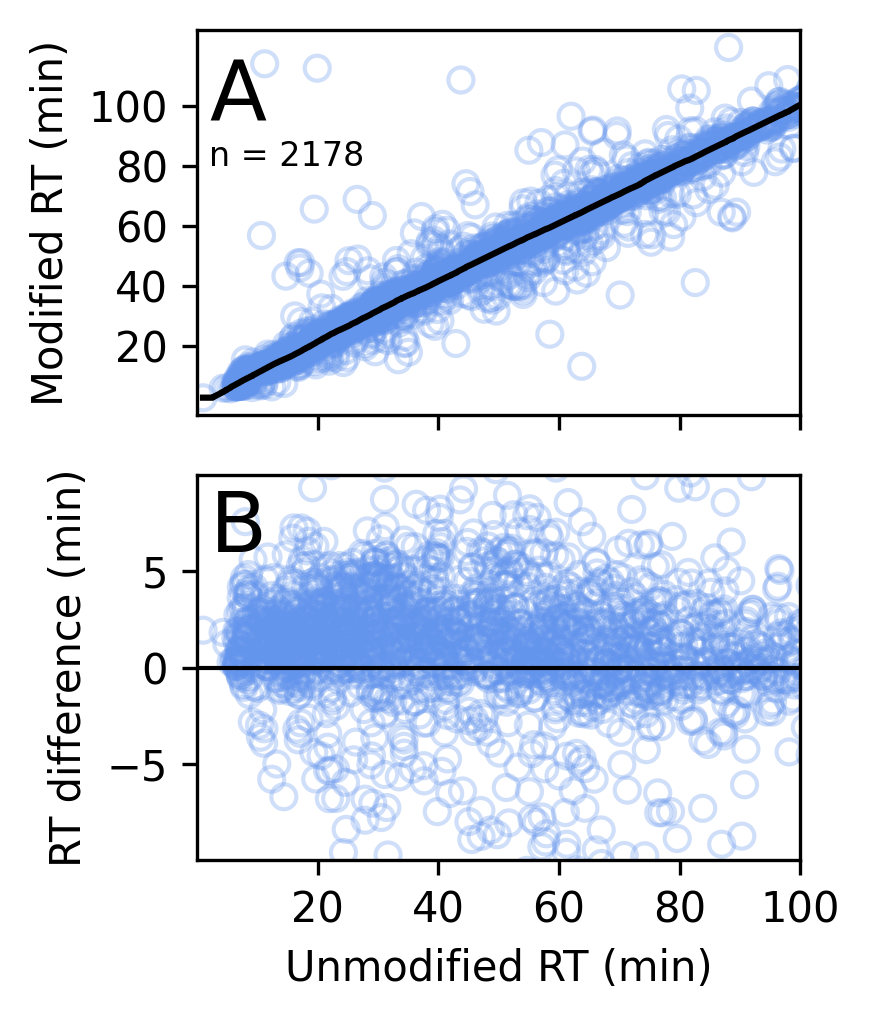

In [5]:
# plot retention time results
fig, axs = plt.subplots(2, 1, figsize=(3,3.5),dpi=300, sharex = True)
ax = axs[0]
ax.set_yticks([20,40,60,80,100])
#ax.set_xticks([20,40,60,80,100])
ax.scatter(np.array(rt_unmod)/60, np.array(rt_mod)/60, edgecolor='cornflowerblue', facecolor='none', marker='o', alpha = 0.3)
ax.text(2,80,'n = '+str(len(rt_unmod)),fontsize=8)
ax.plot(fit_x/60,fit_y/60,color='k')
ax.text(2,95, 'A', fontsize = 20)
ax.set_ylabel('Modified RT (min)')

ax = axs[1]
ax.scatter(np.array(rt_unmod)/60,np.array(rt_diff)/60, edgecolor='cornflowerblue', facecolor='none', marker='o', alpha = 0.3)
ax.axhline(y=0, color='k',linewidth=1,label='Difference = 0')
#ax.plot(fit_x2/60,fit_y2/60,color='darkslateblue',linestyle='dotted',linewidth=2,label='KDE alignment')
ax.set_ylim(-10,10)
ax.set_xlim(0,100)
ax.set_xlabel('Unmodified RT (min)')
ax.set_ylabel('RT difference (min)')
ax.set_xticks([20,40,60,80,100])
ax.set_yticks([-5,0,5])
ax.text(2,6, 'B', fontsize = 20)
plt.tight_layout()
#plt.savefig('ub_paper_fig3a.pdf', dpi=300)

In [6]:
# score all tryptin peptide (modified and unmodified) for global comparison
# unmodified ions
unmod_scores = []

for precursor in loaded_dict['trypsin']['experimental']['unmodified'].keys():
    
    exp_mz = loaded_dict['trypsin']['experimental']['unmodified'][precursor]['mz_array']
    exp_int = loaded_dict['trypsin']['experimental']['unmodified'][precursor]['intensity_array']
    prosit_mz = loaded_dict['trypsin']['Prosit']['unmodified'][precursor]['mz_array']
    prosit_int = loaded_dict['trypsin']['Prosit']['unmodified'][precursor]['intensity_array']

        
    score, exp_mz1, exp_int1, prosit_mz, prosit_int = cosine_similarity(exp_mz, exp_int, prosit_mz, prosit_int, precursor[0], dropb1y1 = True, summed_error=False)
    
    unmod_scores.append(score)

In [7]:
# modified ions
mod_scores = []

# only score ions with a Prosit prediction
exp_precursors = set(loaded_dict['trypsin']['experimental']['modified'].keys())
prosit_precursors = set(loaded_dict['trypsin']['Prosit']['modified'].keys())
overlap_precursors = list(set(exp_precursors).intersection(prosit_precursors))



for precursor in overlap_precursors:
    exp_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
    exp_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
    prosit_mz = loaded_dict['trypsin']['Prosit']['modified'][precursor]['mz_array']
    prosit_int = loaded_dict['trypsin']['Prosit']['modified'][precursor]['intensity_array']

    # mass correct modified fragment ions
    frag_df = return_modified_frags(precursor[0], loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], precursor[1])

    total_mz, total_int = zip(*[
        (frag_df[round(mz, 2)]['mod_ion_mz'] if round(mz, 2) in frag_df else mz, prosit_int[index])
        for index, mz in enumerate(prosit_mz)
    ])
        
    score, exp_mz, exp_int, prosit_mz, prosit_int = cosine_similarity(exp_mz, exp_int, total_mz, total_int, loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'])
    
    mod_scores.append(score)

(0.0, 1.0)

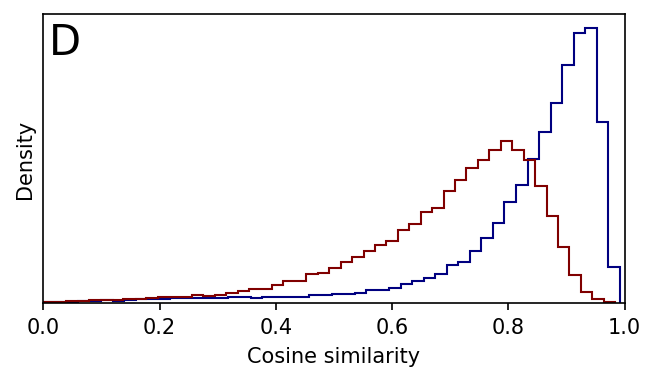

In [8]:
# plot global scores

array_of_scores_score_comparison = [np.array(unmod_scores),np.array(mod_scores)]
fig, ax = plt.subplots(dpi = 150, figsize = (5, 2.5))
label1 = 'Unmodified (n = '+str(len(array_of_scores_score_comparison[0]))+')'
label2 = 'Modified (n = '+str(len(array_of_scores_score_comparison[1]))+')'
ax.hist(array_of_scores_score_comparison[0], color = 'navy',bins=50,histtype='step', density=True,label = label1,)
ax.hist(array_of_scores_score_comparison[1],color = 'maroon',bins=50,histtype='step', density=True,label = label2 )
label2 = 'Modified (n = '+str(len(array_of_scores_score_comparison[1]))+')'
ax.set_xlabel('Cosine similarity')
ax.set_ylabel('Density')
ax.set_yticks([])
ax.text(0.01,5.5,'D', fontsize = 20)
ax.set_xlim(0,1)
#plt.savefig('ub_paper_fig3c.pdf', dpi=300)

In [9]:
print('Unmodified n = '+str(len(array_of_scores_score_comparison[0]))+'')
print('Modified n = '+str(len(array_of_scores_score_comparison[1]))+'')
print('Median Score for unmodified peptides: ', np.median(array_of_scores_score_comparison[0]))
print('Median Score for diGly peptides: ', np.median(array_of_scores_score_comparison[1]))

Unmodified n = 70767
Modified n = 31547
Median Score for unmodified peptides:  0.8788685246065652
Median Score for diGly peptides:  0.734258321232355


In [10]:
# Score peptides based on location of modification

# Create dict that maps precursor length to precursors of that length
length_to_precursor = {x: {} for x in range(7, 36)}

# Create dict that maps peptide length to modified peptides of that length
for precursor in overlap_precursors:
    length = len(precursor[0])
    if 7 <= length <= 35:
        length_to_precursor[length][precursor] = {}

In [ ]:
#score all precursors based on peptide length -- encode residue index of modification in dictionary

for length, precursors in length_to_precursor.items():
    for precursor in precursors:
        modseq = loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq']
        
        # Extract experimental and Prosit data
        exp_data = loaded_dict['trypsin']['experimental']['modified'][precursor]
        prosit_data = loaded_dict['trypsin']['Prosit']['modified'][precursor]
        
        exp_mz = exp_data['mz_array']
        exp_int = exp_data['intensity_array']
        prosit_mz = prosit_data['mz_array']
        prosit_int = prosit_data['intensity_array']
        
        # Mass correct +114 Da on modified fragment ions
        frag_df = return_modified_frags(precursor[0], modseq, precursor[1])
        
        total_mz = []
        total_int = []
        
        for mz, intensity in zip(prosit_mz, prosit_int):
            if round(mz, 2) in frag_df:
                total_mz.append(frag_df[round(mz, 2)]['mod_ion_mz'])
                total_int.append(intensity)
            else:
                total_mz.append(mz)
                total_int.append(intensity)
        
        # Score peptide
        score, exp_mz, exp_int, prosit_int, exp_int = cosine_similarity(exp_mz, exp_int, total_mz, total_int, modseq)
        
        # Store score and modification index in length_to_precursor dictionary
        length_to_precursor[length][precursor]['score'] = score
        length_to_precursor[length][precursor]['modindex'] = modseq.find('[+114.042927]')

In [ ]:
# create score arrays based on residue intex for all modified peptides on length 17 aa

n = 17

index_to_score = {x: [] for x in range(1, n)}

for precursor in length_to_precursor[n]:
    if 'modindex' in length_to_precursor[n][precursor]:
        index = length_to_precursor[n][precursor]['modindex']
        score = length_to_precursor[n][precursor].get('score', -1)
        if index < n:
            index_to_score[index].append(score)
            
array_of_scores_residue_index = [np.array(index_to_score[x]) for x in range(1, n)]

In [ ]:
# repeat analysis for all peptides from 8-17 AA long

mod_index_dict = {n: {x: [] for x in range(1, n)} for n in range(8, 18)}

for n in range(8, 18):
    for precursor in length_to_precursor[n]:
        if 'modindex' in length_to_precursor[n][precursor]:
            index = length_to_precursor[n][precursor]['modindex']
            score = length_to_precursor[n][precursor].get('score')
            if index < n:
                mod_index_dict[n][index].append(score)

In [ ]:
# plot all distributions
fig2, axes2 = plt.subplots(nrows=1, ncols=16, figsize=(7.5, 0.5), dpi = 300, sharey = True)
ax = axes2[0]
ax.text(-0.5,1,'A', fontsize = 20)
#ax.set_ylabel('Density', fontsize = 5)
for index, score_array in enumerate(array_of_scores_residue_index):
    ax = axes2[index]
    ax.hist(score_array, color = 'navy',bins=25,histtype='step', density=True)
    ax.set_xticks([])
    ax.set_yticks([])

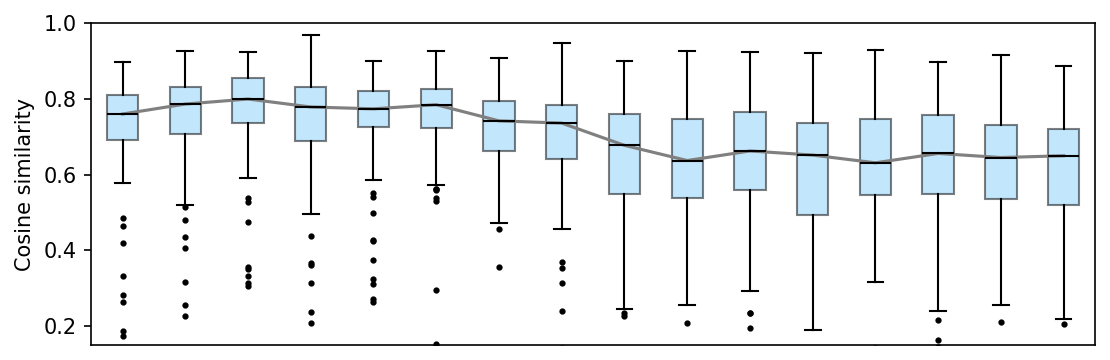

In [15]:
# boxplots
median_array_for_modindex = []
n_list = []
for score_array in array_of_scores_residue_index:
    median = np.median(score_array)
    median_array_for_modindex.append(median)
    n = len(score_array)
    n_list.append(n)




fig3, axes3 = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 2.5), dpi = 150)
ax = axes3
ax.boxplot(array_of_scores_residue_index, patch_artist=True,  medianprops=dict(color='k'), boxprops=dict(facecolor='lightskyblue', alpha = 0.5),flierprops=dict(marker='o', markersize=2, markerfacecolor='k', alpha=1),)
ax.plot(list(range(1, 17, 1)), median_array_for_modindex, color = 'grey')
ax.set_ylabel('Cosine similarity')
ax.set_xticks([])
ax.set_ylim(0.15,1)
plt.tight_layout()

Text(0, 0.5, 'N')

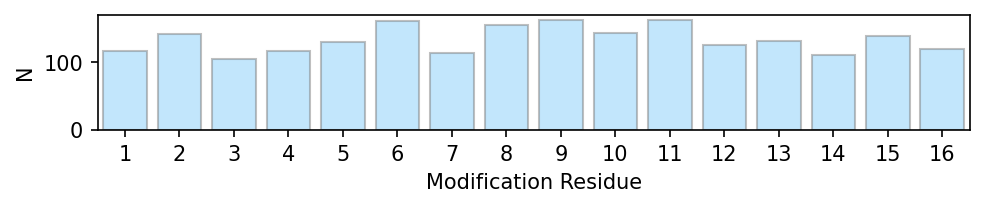

In [16]:
# plot number of peptides in each plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 1), dpi = 150)
ax.bar(list(range(1, 17, 1)),n_list, color = 'lightskyblue', alpha = 0.5, edgecolor = 'grey')
ax.set_xticks(list(range(1, 17, 1)))
ax.set_xlabel('Modification Residue')
ax.set_xlim(0.5,16.5)
ax.set_ylabel('N')

In [17]:
# calculate fragment ion intensity ratios
mod_index_to_ratio = {n: {'mod_ratio': [], 'nomod_ratio': []} for n in range(1, 17)}

index_list, nomod_list, mod_list = [], [], []

for precursor in overlap_precursors:
    exp_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
    exp_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
    prosit_mz = loaded_dict['trypsin']['Prosit']['modified'][precursor]['mz_array']
    prosit_int = loaded_dict['trypsin']['Prosit']['modified'][precursor]['intensity_array']
    modseq = loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq']
    
    # mass correct Prosit predictions
    frag_df = return_modified_frags(precursor[0], modseq, precursor[1])
    
    # find mod index
    mod_index = modseq.find('[+114.042927]')
    if not (1 <= mod_index < 17):
        continue
    
    total_mz, total_int = [], []
    
    # perform mass shift
    for mz, intensity in zip(prosit_mz, prosit_int):
        rounded_mz = round(mz, 2)
        if rounded_mz in frag_df:
            total_mz.append(frag_df[rounded_mz]['mod_ion_mz'])
            total_int.append(intensity)
        else:
            total_mz.append(mz)
            total_int.append(intensity)
    
    # score to return only the ions that Prosit predicts
    score, exp_mz, exp_int, prosit_mz, prosit_int = cosine_similarity(exp_mz, exp_int, total_mz, total_int, modseq, softmax = False)
    
    # create list of modified fragment mzs
    mod_frag_mzs = [frag['mod_ion_mz'] for frag in frag_df.values()]
    round_mzs = np.round(mod_frag_mzs, 2)
    
    # sum intensities for Prosit predictions
    prosit_mod_int = sum(intensity for mz, intensity in zip(prosit_mz, prosit_int) if round(mz, 2) in round_mzs)
    prosit_nomod_int = sum(intensity for mz, intensity in zip(prosit_mz, prosit_int) if round(mz, 2) not in round_mzs)
    
    # sum intensities for experimental data
    exp_mod_int = sum(intensity for mz, intensity in zip(exp_mz, exp_int) if round(mz, 2) in round_mzs)
    exp_nomod_int = sum(intensity for mz, intensity in zip(exp_mz, exp_int) if round(mz, 2) not in round_mzs)
    
    # calculate ratios
    ratio_unmod = exp_nomod_int / (prosit_nomod_int + 1e-10)
    ratio_mod = exp_mod_int / (prosit_mod_int + 1e-10)
    
    mod_index_to_ratio[mod_index]['mod_ratio'].append(ratio_mod)
    mod_index_to_ratio[mod_index]['nomod_ratio'].append(ratio_unmod)
    
    index_list.append(mod_index)
    nomod_list.append(ratio_unmod)
    mod_list.append(ratio_mod)

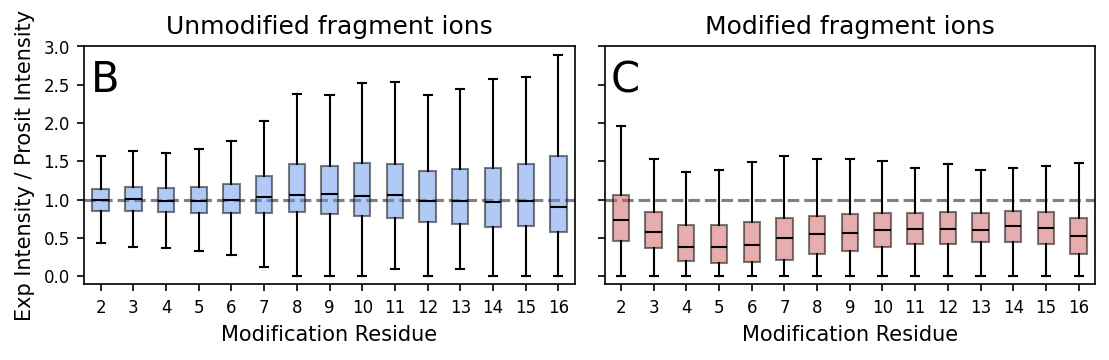

In [18]:
# plot results
n_list = list(mod_index_to_ratio.keys())
array_of_scores_mod = [np.array(mod_index_to_ratio[n]['mod_ratio']) for n in n_list]
array_of_scores_nomod = [np.array(mod_index_to_ratio[n]['nomod_ratio']) for n in n_list]

fig4, axes4 = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 2.5), dpi = 150, sharey= True)
ax = axes4[0]
ax.axhline(y=1, color='gray', linestyle='--')
ax.boxplot(array_of_scores_nomod, showfliers=False, patch_artist=True,  medianprops=dict(color='k'), boxprops=dict(facecolor='cornflowerblue', alpha = 0.5))
ax.set_ylabel('Exp Intensity / Prosit Intensity')
ax.set_xlabel('Modification Residue')
ax.set_xlim(1.5,16.5)
ax.tick_params(labelsize=8)
ax.set_title('Unmodified fragment ions')
ax.text(1.7,2.4,'B', fontsize = 20)
ax = axes4[1]
ax.axhline(y=1, color='gray', linestyle='--')
ax.boxplot(array_of_scores_mod, showfliers=False, patch_artist=True,  medianprops=dict(color='k'), boxprops=dict(facecolor='indianred', alpha = 0.5))
ax.set_ylim(-0.10,3)
ax.set_xlim(1.5,16.5)
ax.tick_params( labelsize=8)
ax.set_xlabel('Modification Residue')
ax.set_title('Modified fragment ions')
ax.text(1.7,2.4,'C', fontsize = 20)
plt.tight_layout()

In [19]:
# search for mass loss
# only use peptides with a c terminal modification
cterm_mod_peptides = []
for precursor in overlap_precursors:
    modseq = loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq']
    modindex = modseq.find('[+114.042927]')
    if modindex >= 10 and modindex < len(precursor[0]):
        cterm_mod_peptides.append(precursor)

In [20]:
# create list of mass offsets
chem_formula_tomass = {}
mass_to_cf = {}

for c in range(10):
    for n in range(6):
        for o in range(6):
            for h in range(30):
                mass = c * masses['carbon'] + n * masses['nitrogen'] + o * masses['oxygen'] + h * masses['hydrogen']
                DOU = (2 * c + 2 + n - h) / 2  # calculate degrees of unsaturation
                if mass < 120 and DOU >= 0:  # filter out negative degrees of unsaturation because these neutral losses are not chemically feasible
                    chemical_formula = f'C{c}H{h}N{n}O{o}'
                    chem_formula_tomass[chemical_formula] = mass
                    mass_to_cf[mass] = chemical_formula

In [29]:
# perform mass offset scores
massshift_toscore = {massshift: [] for massshift in chem_formula_tomass.values()}
massshift_toerror = {massshift: [] for massshift in chem_formula_tomass.values()}

length = len(cterm_mod_peptides)

for index, precursor in enumerate(cterm_mod_peptides):
    # track progress
    if index % 500 == 0:
        progress = round((index / length) * 100)
        print(f'{progress}% Done')
    if index == length - 1:
        print('100% Done')
        
    exp_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
    exp_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
    prosit_mz = loaded_dict['trypsin']['Prosit']['modified'][precursor]['mz_array']
    prosit_int = loaded_dict['trypsin']['Prosit']['modified'][precursor]['intensity_array']
    sequence = precursor[0]
    charge = precursor[1]
    modseq = loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq']

    mzs_to_shift, prosit_mz_mods, prosit_int_mods = return_mzs_to_shift(sequence, modseq, charge, prosit_mz, prosit_int)
    
    for massshift in chem_formula_tomass.values():
        prozit_mz_altered = np.copy(prosit_mz_mods)
        
        for mz, mz_charge in mzs_to_shift.items():  # mass shift ions
            index = np.where(prozit_mz_altered == mz)
            prozit_mz_altered[index] = mz + 114.042928 / mz_charge - massshift / mz_charge
        
        # Score shifted spectra
        score, exp_mz_2, exp_int_2, prosit_mz_2, prosit_int_2, error = cosine_similarity(
            exp_mz, exp_int, prozit_mz_altered, prosit_int_mods, modseq, summed_error=True
        )
        
        massshift_toscore[massshift].append(score)
        if error != 'nan':
            massshift_toerror[massshift].append(error)

0% Done
9% Done
18% Done
27% Done
36% Done
45% Done
54% Done
62% Done
71% Done
80% Done
89% Done
98% Done
100% Done


Median Score: 0.6639828, Mass Error: 1.1534, Mass Shift: 0.0000, Chemical Formula: C0H0N0O0
Median Score: 0.3170317, Mass Error: 1.6517, Mass Shift: 18.0106, Chemical Formula: C0H2N0O1
Median Score: 0.3065577, Mass Error: 2.4623, Mass Shift: 57.0201, Chemical Formula: C0H1N4O0
Median Score: 0.3065577, Mass Error: 1.4642, Mass Shift: 57.0215, Chemical Formula: C2H3N1O1
Median Score: 0.2994233, Mass Error: 3.1678, Mass Shift: 114.0416, Chemical Formula: C2H4N5O1
Median Score: 0.2977088, Mass Error: 2.0715, Mass Shift: 114.0429, Chemical Formula: C4H6N2O2
Median Score: 0.2850969, Mass Error: 10.6522, Mass Shift: 114.0344, Chemical Formula: C8H4N1O0
Median Score: 0.2971097, Mass Error: 6.3758, Mass Shift: 114.0470, Chemical Formula: C9H6N0O0


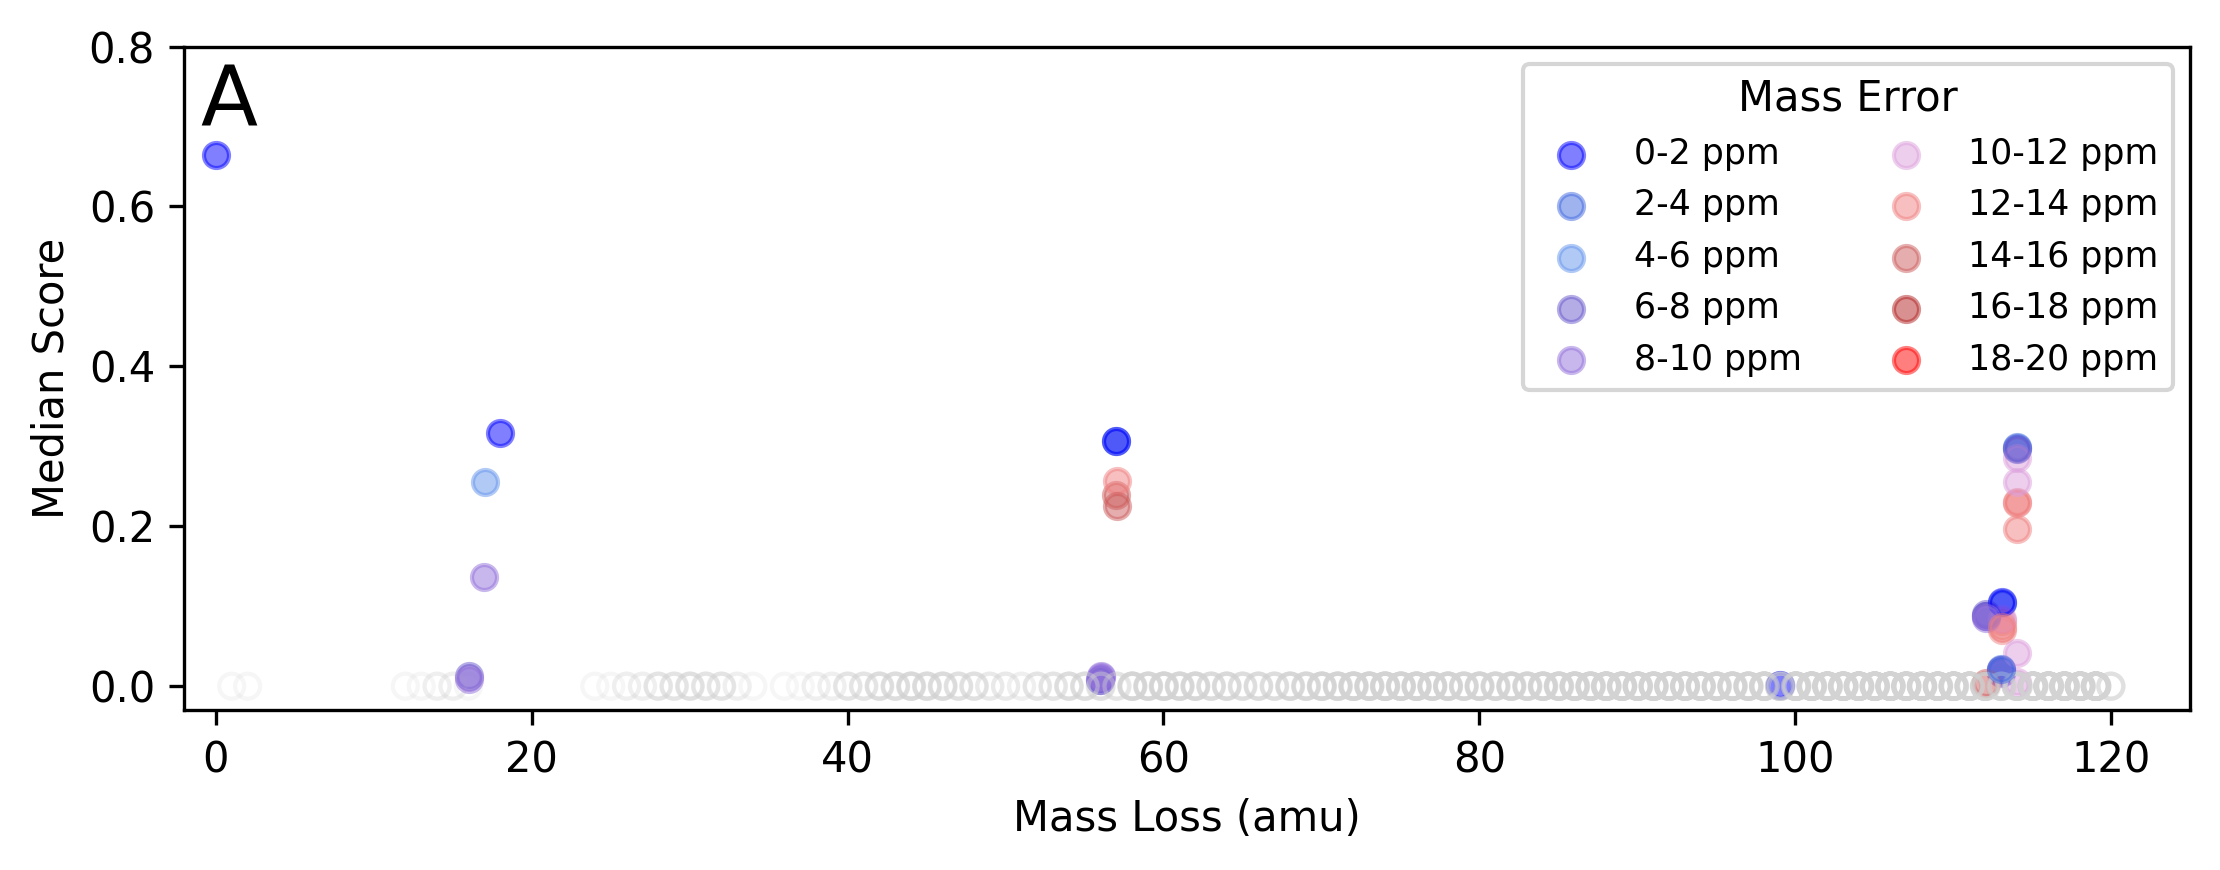

In [30]:
mass_SHIFT = []
median_array = []
error_array = []

fig, ax = plt.subplots(dpi=300, figsize=(7.5, 3))

# Define colors and labels
ppm_labels_colors = [
    (0, 2, 'blue'),
    (2, 4, 'royalblue'),
    (4, 6, 'cornflowerblue'),
    (6, 8, 'slateblue'),
    (8, 10, 'mediumpurple'),
    (10, 12, 'plum'),
    (12, 14, 'lightcoral'),
    (14, 16, 'indianred'),
    (16, 18, 'firebrick'),
    (18, 20, 'red'),
]

# Initialize scatter plot for labels
for low, high, color in ppm_labels_colors:
    ax.scatter(-10, 0, alpha=0.5, color=color, label=f'{low}-{high} ppm')

# Plot data points
for mass_shift in chem_formula_tomass.values():
    mass_SHIFT.append(mass_shift)
    score_array = np.array(massshift_toscore[mass_shift])
    median = np.median(score_array)
    median_array.append(median)
    error_array = np.array(massshift_toerror[mass_shift])
    error = np.median(error_array)
    if median > 0.28:
        print(f'Median Score: {median:.7f}, Mass Error: {error:.4f}, Mass Shift: {mass_shift:.4f}, Chemical Formula: {mass_to_cf[mass_shift]}')
    
    if median < 0.001:
        ax.scatter(mass_shift, median, alpha=0.2, facecolors='none', marker='o', edgecolor='lightgrey')
    else:
        for low, high, color in ppm_labels_colors:
            if low < error <= high:
                ax.scatter(mass_shift, median, alpha=0.5, color=color)
                break

ax.set_xlabel('Mass Loss (amu)')
ax.set_ylabel('Median Score')
legend = ax.legend(loc='best', ncols=2, fontsize='small')
legend.set_title('Mass Error')
ax.set_xlim(-2, 125)
ax.set_ylim(-0.03, 0.8)
ax.text(-1, 0.7, 'A', fontsize=20)
plt.tight_layout()

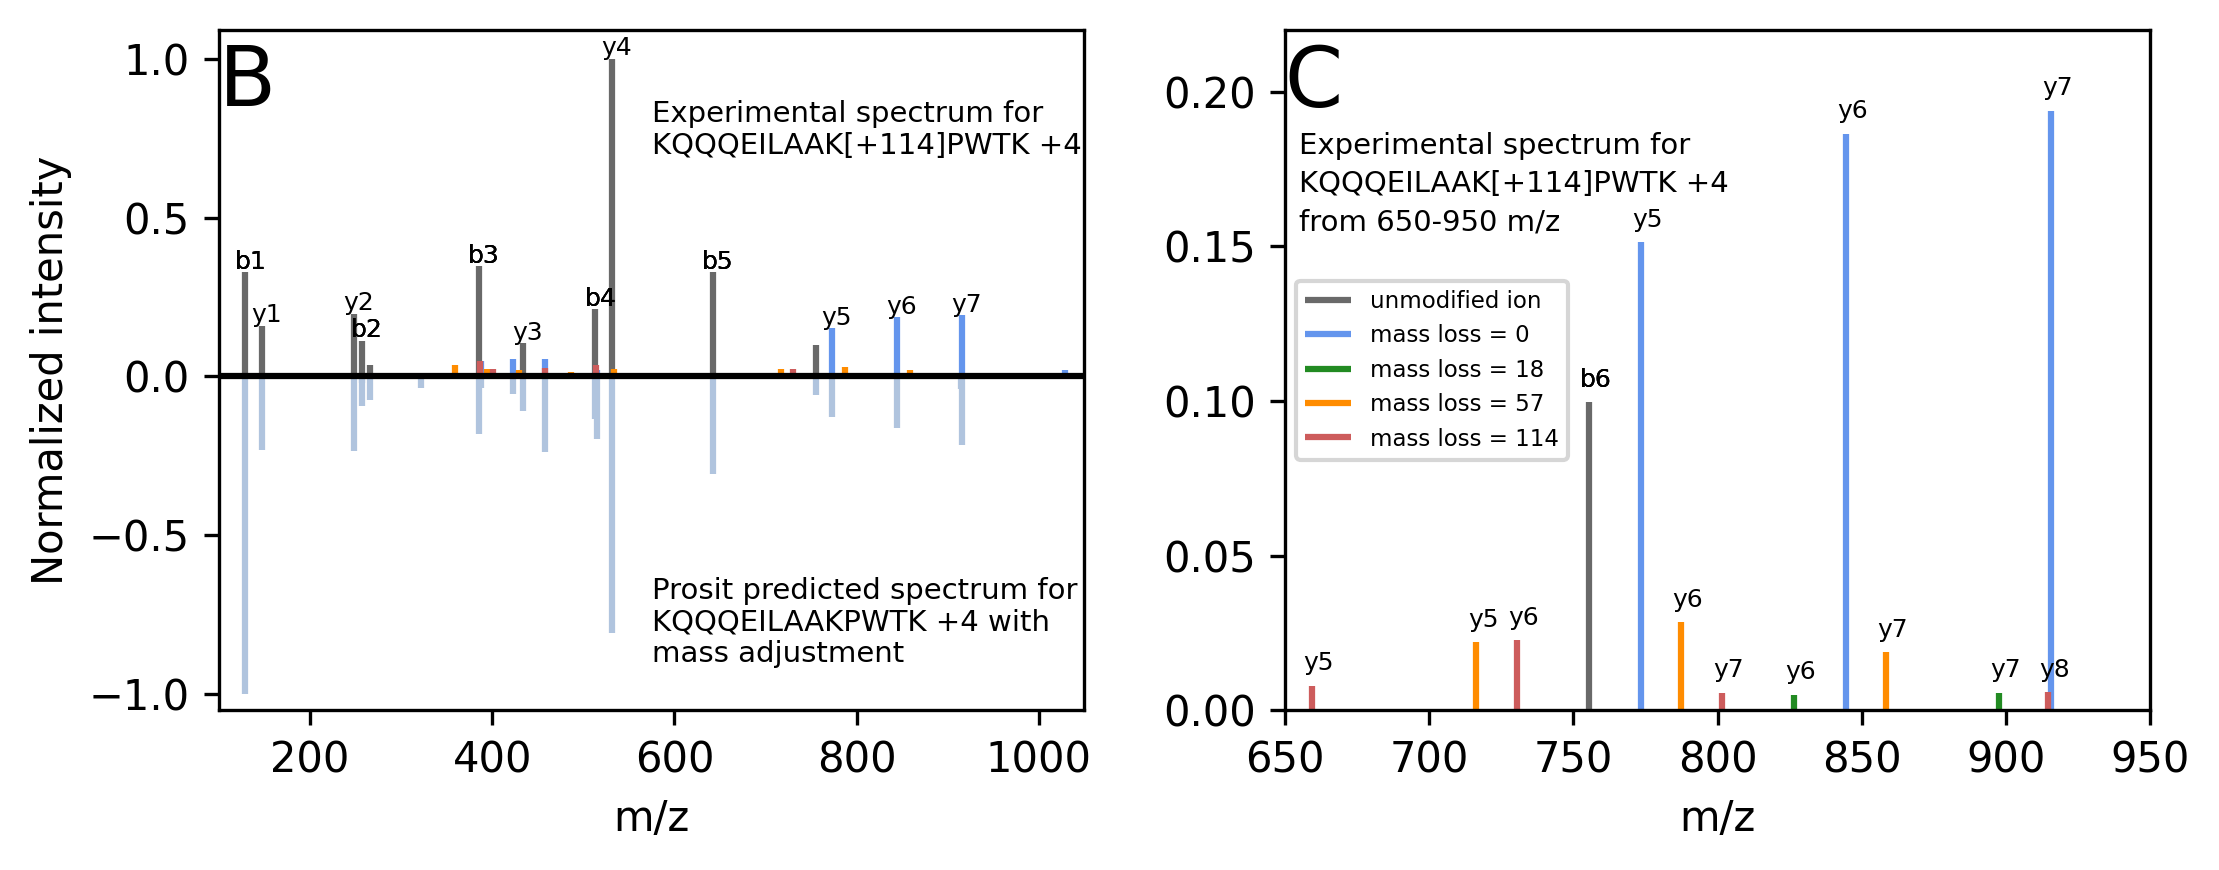

In [31]:
# plot experimental spectrum
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3), dpi=300)
ax = axes[0]

mod_masses = [114.04292799999999, 57.021463999999995, 96.032363]
precursor = ('KQQQEILAAKPWTK', 4)
mod_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
mod_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
mod_int = np.array(mod_int) / max(mod_int)
mz_to_int = dict(zip(mod_mz, mod_int))
frag_ion_df = annotate_ions_for_plotting(precursor[0], loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], precursor[1])

mod_mzs = []
for r in frag_ion_df.to_dict(orient='records'):
    if r['Mod'] == 1:
        ion_type, ion_charge = r['ion_type'], r['ion_charge']
        for mass in mod_masses:
            mz = r['ion_mz'] + mass / ion_charge
            mod_mzs.append({'ion_type': ion_type, 'Mod': 1, 'ion_mz': mz, 'ion_charge': ion_charge, 'mass_shift': mass})

mod_df = pd.DataFrame(mod_mzs)
total_frag_df = pd.concat([frag_ion_df, mod_df], ignore_index=True)

unmod_frags, mod_frags_114, mod_frags_96, mod_frags_57, mod_frags_0 = {}, {}, {}, {}, {}
text_list, x_list, y_list = [], [], []

for mz, intensity in mz_to_int.items():
    lower_lim, upper_lim = mz * (1 - 20e-6), mz * (1 + 20e-6)
    for r in total_frag_df.to_dict(orient='records'):
        if lower_lim < r['ion_mz'] < upper_lim:
            ion_type, mod, mass_shift = r['ion_type'], r['Mod'], r['mass_shift']
            if mod == 0:
                unmod_frags[mz] = intensity
                text_list.append(ion_type)
                x_list.append(mz)
                y_list.append(intensity)
            elif mod == 1:
                if mass_shift == 57.021463999999995:
                    mod_frags_57[mz] = intensity
                elif mass_shift == 96.032363:
                    mod_frags_96[mz] = intensity
                elif mass_shift == 114.04292799999999:
                    mod_frags_114[mz] = intensity
                else:
                    mod_frags_0[mz] = intensity
                text_list.append(ion_type)
                x_list.append(mz)
                y_list.append(intensity)

# plot experimental spectrum
ax.vlines(unmod_frags.keys(), 0, unmod_frags.values(), color='dimgrey', label='unmodified ion')
ax.vlines(mod_frags_114.keys(), 0, mod_frags_114.values(), color='cornflowerblue', label='mass loss = 0')
ax.vlines(mod_frags_96.keys(), 0, mod_frags_96.values(), color='forestgreen', label='mass loss = 18')
ax.vlines(mod_frags_57.keys(), 0, mod_frags_57.values(), color='darkorange', label='mass loss = 57')
ax.vlines(mod_frags_0.keys(), 0, mod_frags_0.values(), color='indianred', label='mass loss = 114')
ax.set_xlim(100, 1050)
ax.set_ylim(-1.05, 1.09)
for i, text in enumerate(text_list):
    if y_list[i] > 0.1:
        ax.text(x_list[i] - 12, y_list[i] + 0.01, text, fontsize=6)
ax.set_xlabel('m/z')
ax.set_ylabel('Normalized intensity')
ax.text(575, 0.8, 'Experimental spectrum for', fontsize=7)
ax.text(575, 0.7, 'KQQQEILAAK[+114]PWTK +4', fontsize=7)
ax.text(100, 0.85, 'B', fontsize=20)

# plot predicted spectrum
prosit_mz = loaded_dict['trypsin']['Prosit']['modified'][precursor]['mz_array']
prosit_int = loaded_dict['trypsin']['Prosit']['modified'][precursor]['intensity_array']
frag_df = return_modified_frags(precursor[0], loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], precursor[1])

total_mz, total_int = [], []
for mz, intensity in zip(prosit_mz, prosit_int):
    if round(mz, 2) in frag_df:
        total_mz.append(frag_df[round(mz, 2)]['mod_ion_mz'])
        total_int.append(intensity)
    else:
        total_mz.append(mz)
        total_int.append(intensity)

ax.vlines(total_mz, 0, -1 * np.array(total_int), color='lightsteelblue')
ax.plot([0, 1300], [0, 0], color='k')
ax.text(575, -0.7, 'Prosit predicted spectrum for', fontsize=7)
ax.text(575, -0.8, 'KQQQEILAAKPWTK +4 with', fontsize=7)
ax.text(575, -0.9, 'mass adjustment', fontsize=7)

# plot zoomed-in spectrum
ax = axes[1]
ax.vlines(unmod_frags.keys(), 0, unmod_frags.values(), color='dimgrey', label='unmodified ion')
ax.vlines(mod_frags_114.keys(), 0, mod_frags_114.values(), color='cornflowerblue', label='mass loss = 0')
ax.vlines(mod_frags_96.keys(), 0, mod_frags_96.values(), color='forestgreen', label='mass loss = 18')
ax.vlines(mod_frags_57.keys(), 0, mod_frags_57.values(), color='darkorange', label='mass loss = 57')
ax.vlines(mod_frags_0.keys(), 0, mod_frags_0.values(), color='indianred', label='mass loss = 114')
ax.set_xlim(650, 950)
ax.set_ylim(0, 0.22)
for i, text in enumerate(text_list):
    if 650 < x_list[i] < 950:
        ax.text(x_list[i] - 3, y_list[i] + 0.005, text, fontsize=6)
ax.set_xlabel('m/z')
ax.text(650, 0.195, 'C', fontsize=20)
ax.text(655, 0.18, 'Experimental spectrum for', fontsize=7)
ax.text(655, 0.1675, 'KQQQEILAAK[+114]PWTK +4', fontsize=7)
ax.text(655, 0.155, 'from 650-950 m/z', fontsize=7)
legend = ax.legend(loc='center left', fontsize=5.5)

plt.tight_layout()

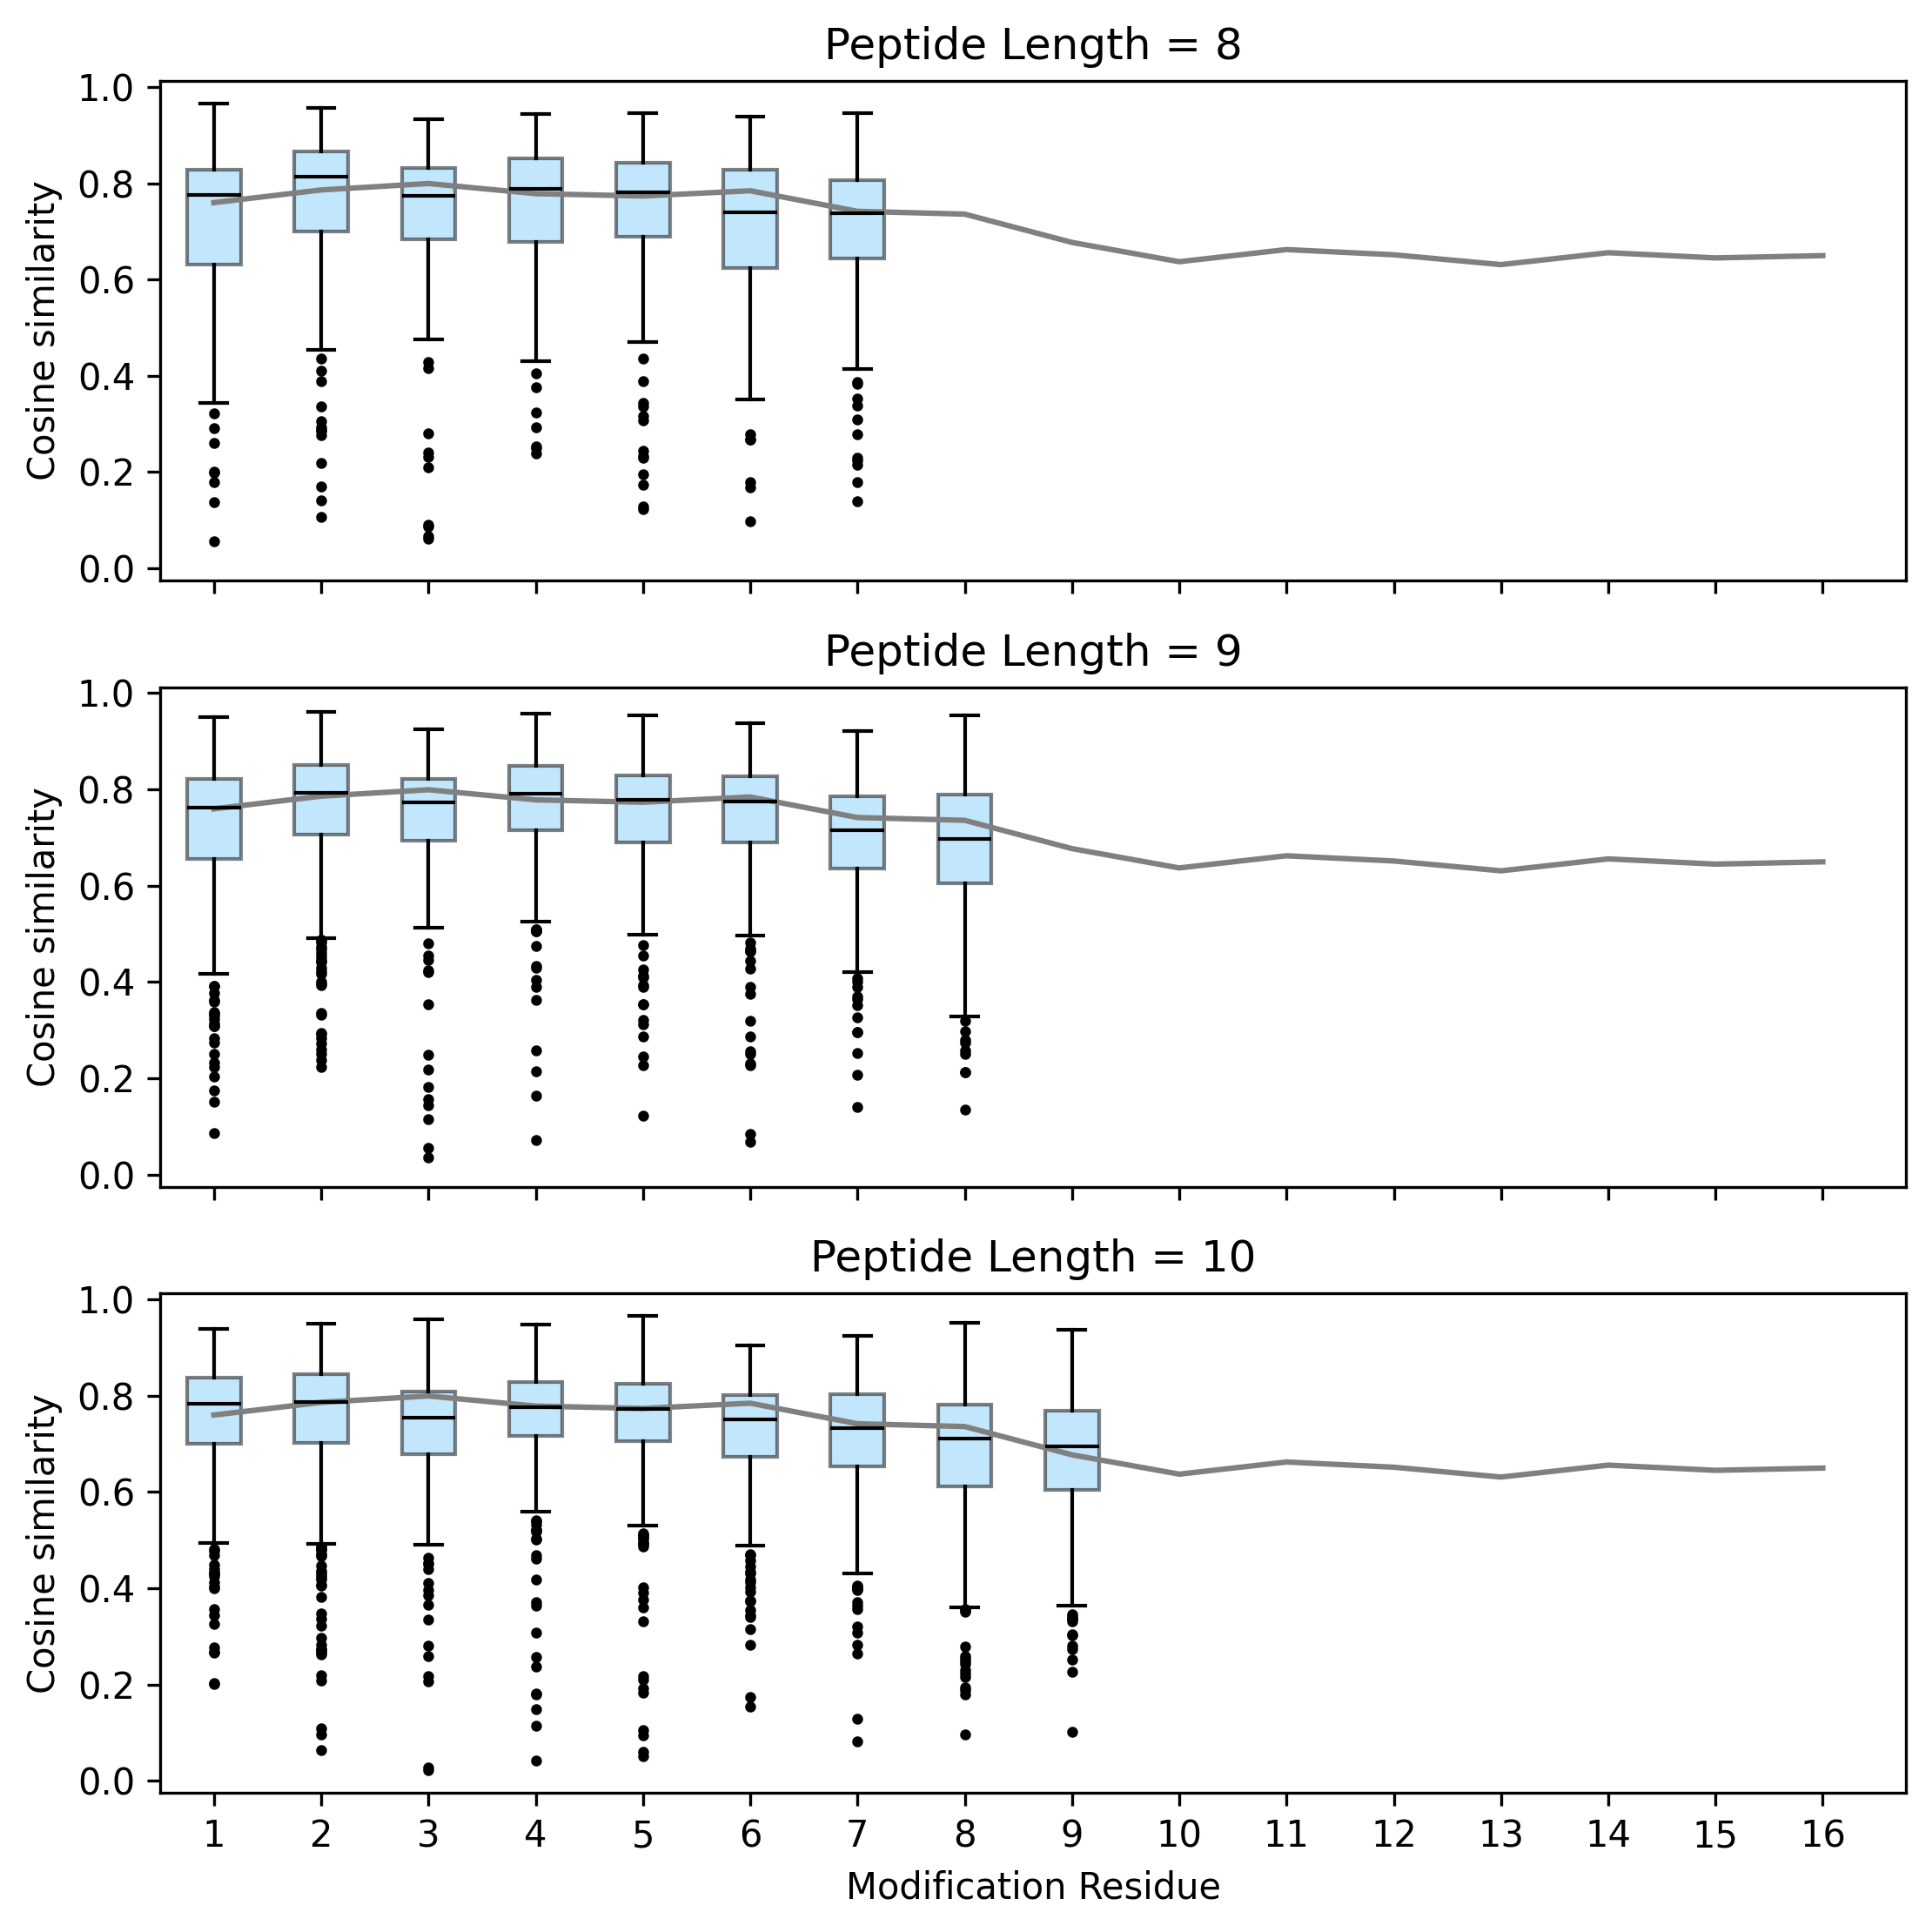

In [32]:
# plot supplimental figures
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 7.5), dpi=300, sharey=True, sharex=True)

for n in range(8, 11):
    ax = axes[n-8]
    array_of_scores = []
    for x in range(1, n):
        score_array = np.array(mod_index_dict[n][x])
        array_of_scores.append(score_array)
    title_string = 'Peptide Length = ' + str(n)
    ax.set_title(title_string)
    ax.boxplot(array_of_scores, patch_artist=True, medianprops=dict(color='k'), boxprops=dict(facecolor='lightskyblue', alpha=0.5), flierprops=dict(marker='o', markersize=2, markerfacecolor='k', alpha=1))
    ax.plot(list(range(1, 17)), median_array_for_modindex, color='grey')
    ax.set_ylabel('Cosine similarity')

    
    # Set xticks and xticklabels
    ax.set_xticks(range(1, 17))  # Set xticks for each subplot
    ax.set_xticklabels(range(1, 17))  # Set xticklabels for each subplot
ax.set_xlabel('Modification Residue')
plt.tight_layout()

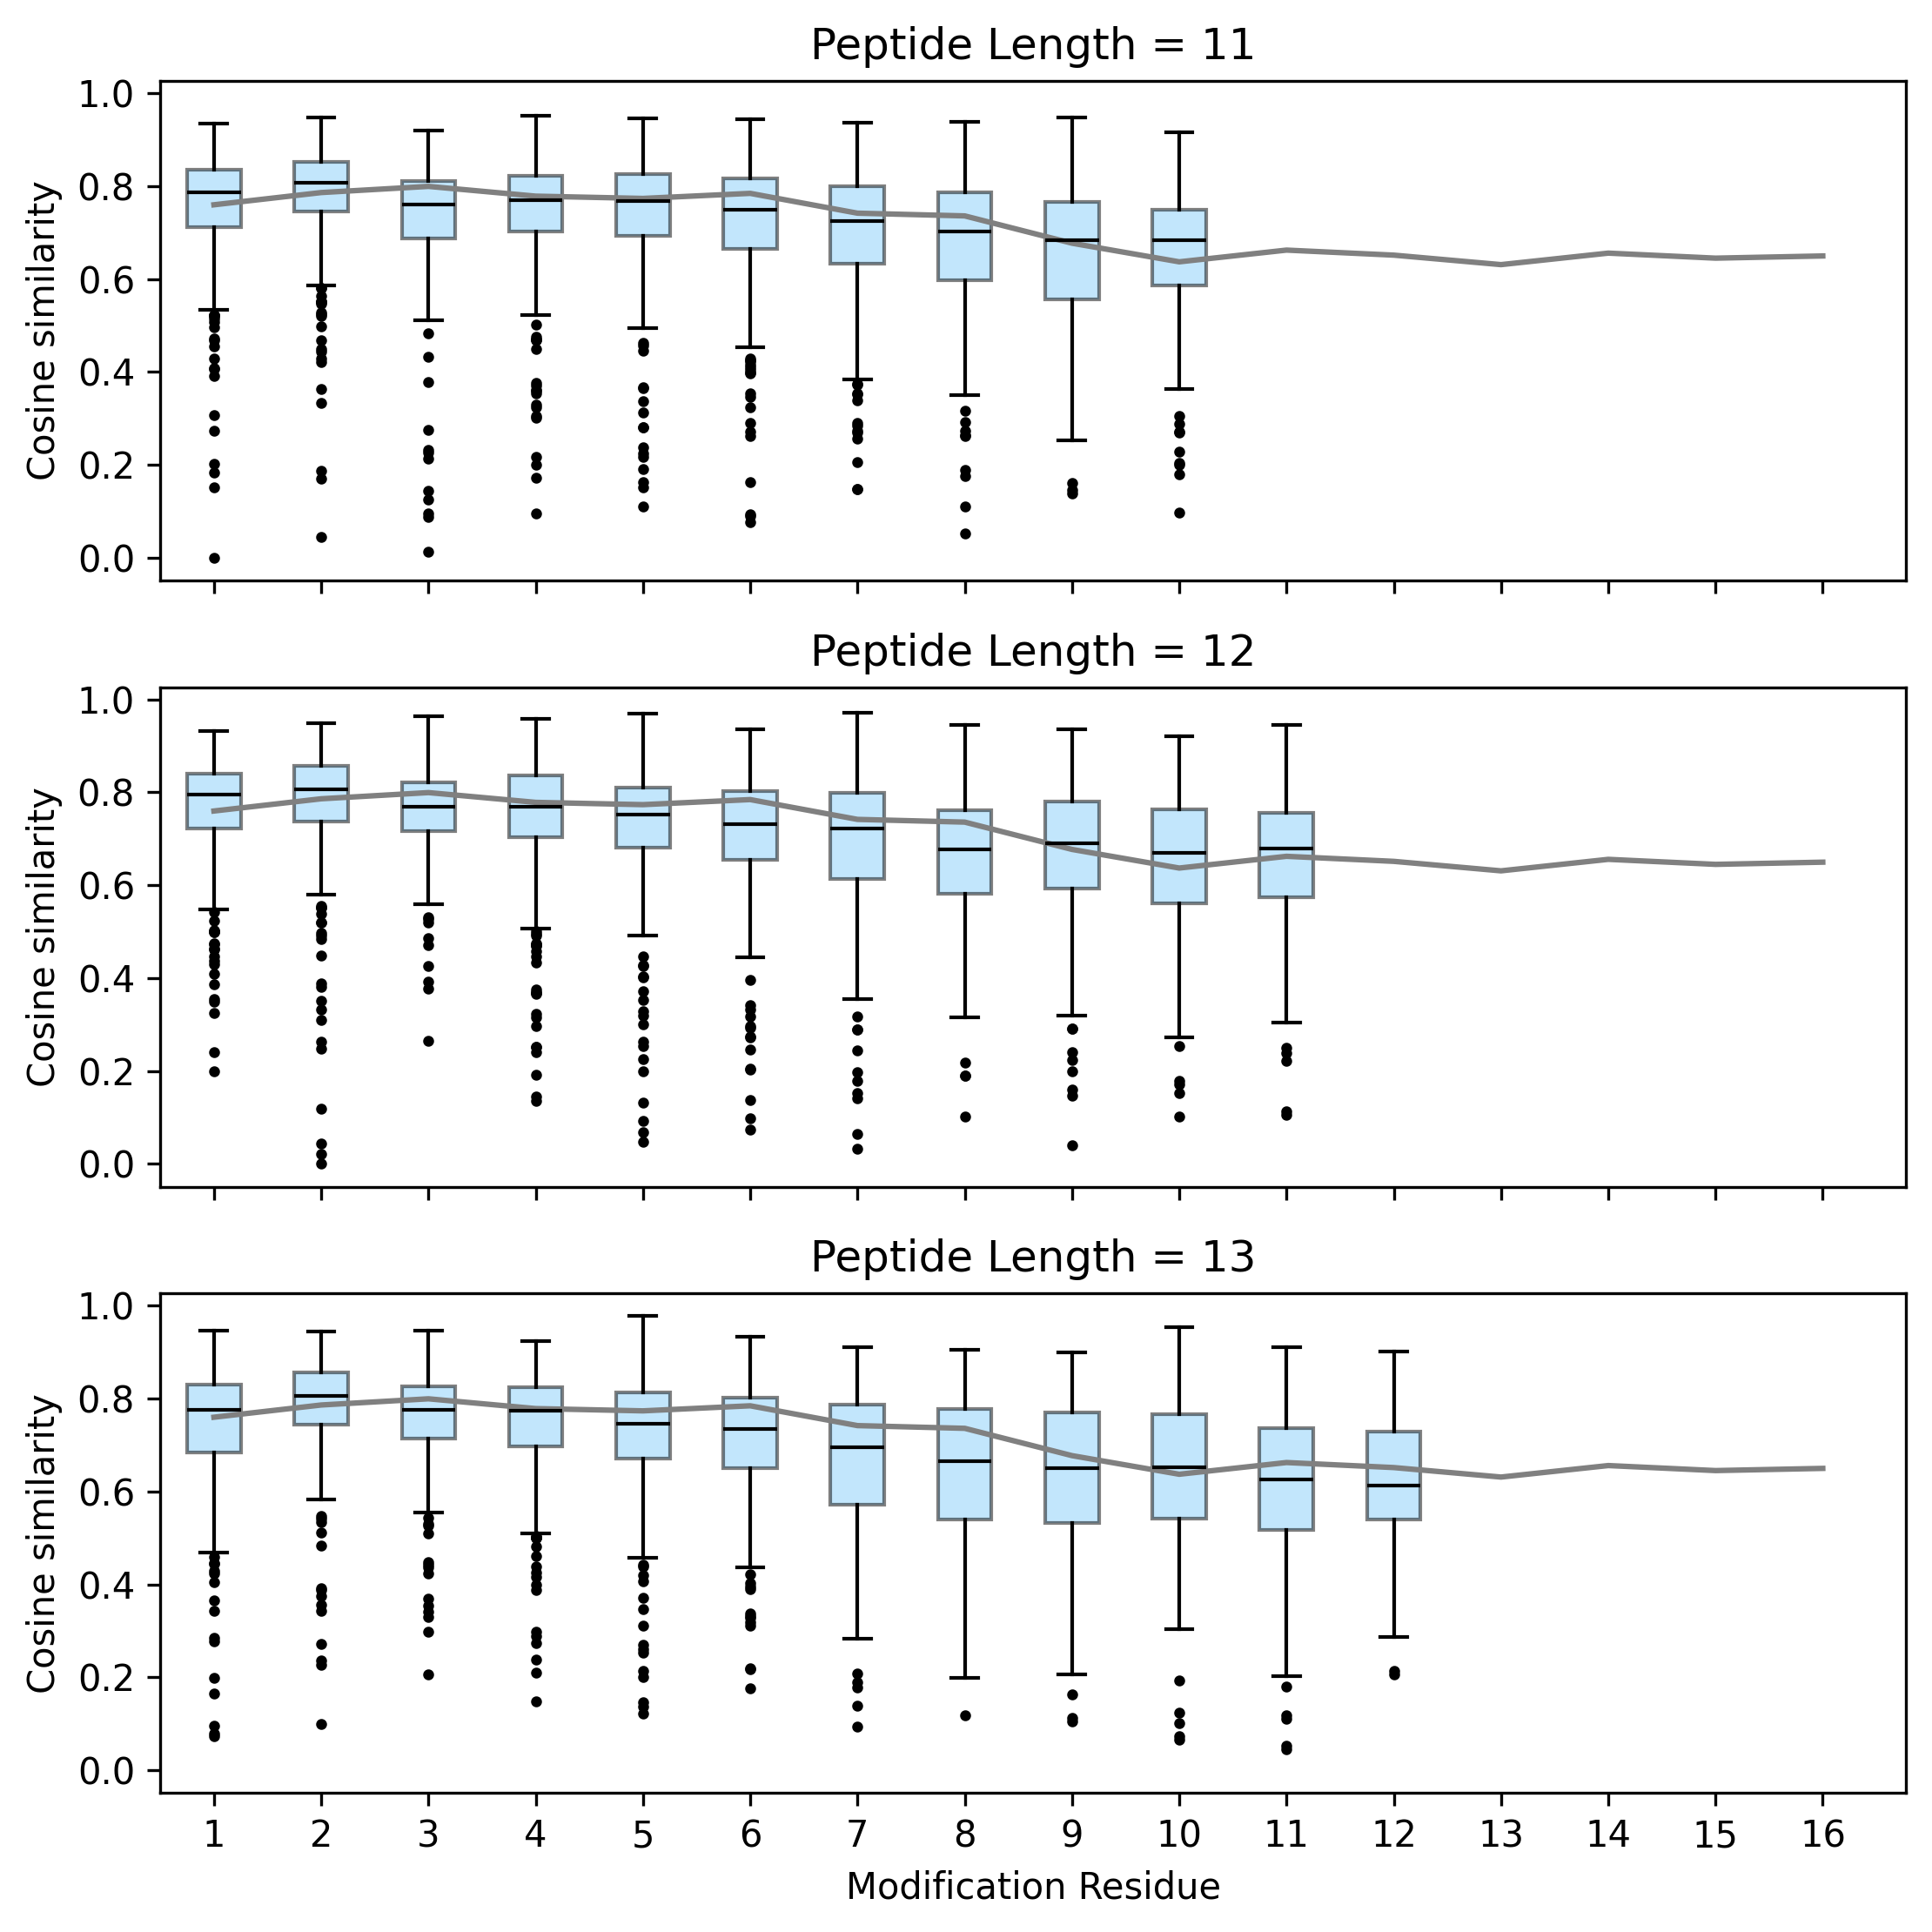

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 7.5), dpi=300, sharey=True, sharex=True)
for n in range(11, 14):
    ax = axes[n-11]
    array_of_scores = []
    for x in range(1, n):
        score_array = np.array(mod_index_dict[n][x])
        array_of_scores.append(score_array)
    title_string = 'Peptide Length = ' + str(n)
    ax.set_title(title_string)
    ax.boxplot(array_of_scores, patch_artist=True, medianprops=dict(color='k'), boxprops=dict(facecolor='lightskyblue', alpha=0.5), flierprops=dict(marker='o', markersize=2, markerfacecolor='k', alpha=1))
    ax.plot(list(range(1, 17)), median_array_for_modindex, color='grey')
    ax.set_ylabel('Cosine similarity')

    
    # Set xticks and xticklabels
    ax.set_xticks(range(1, 17))  # Set xticks for each subplot
    ax.set_xticklabels(range(1, 17))  # Set xticklabels for each subplot
ax.set_xlabel('Modification Residue')
plt.tight_layout()
plt.show()

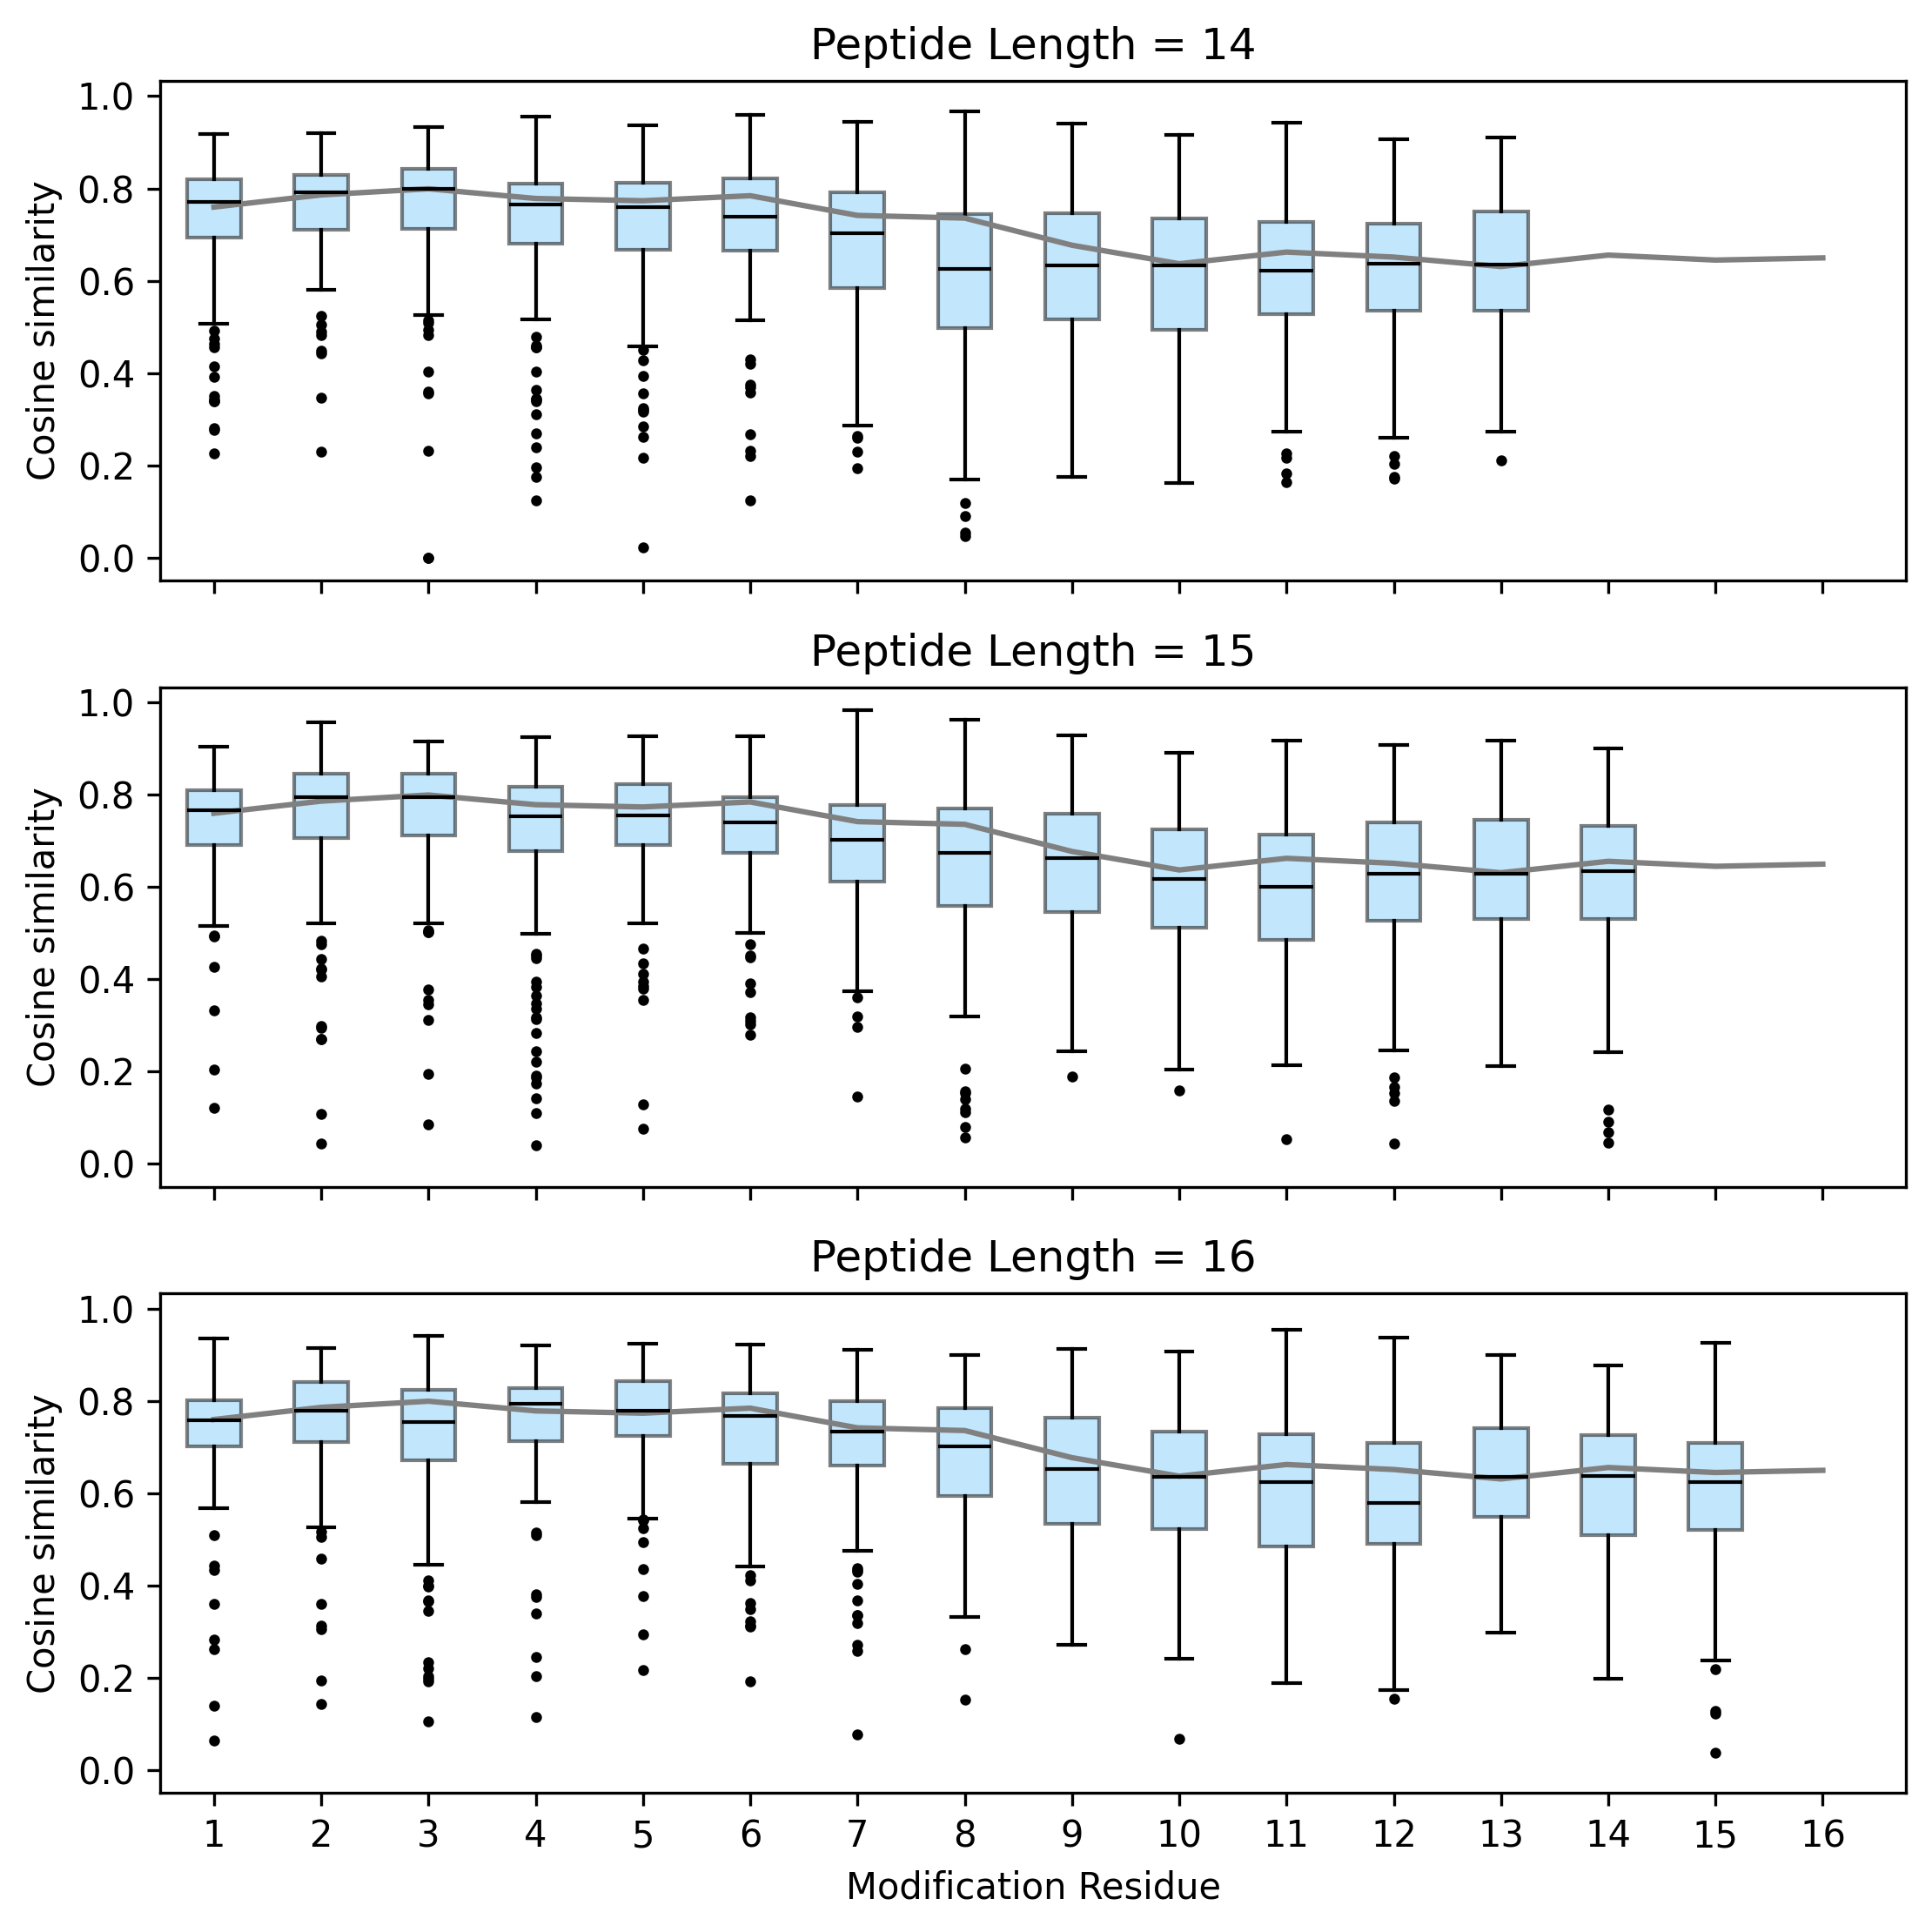

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 7.5), dpi=300, sharey=True, sharex=True)
for n in range(14, 17):
    ax = axes[n-14]
    array_of_scores = []
    for x in range(1, n):
        score_array = np.array(mod_index_dict[n][x])
        array_of_scores.append(score_array)
    title_string = 'Peptide Length = ' + str(n)
    ax.set_title(title_string)
    ax.boxplot(array_of_scores, patch_artist=True, medianprops=dict(color='k'), boxprops=dict(facecolor='lightskyblue', alpha=0.5), flierprops=dict(marker='o', markersize=2, markerfacecolor='k', alpha=1))
    ax.plot(list(range(1, 17)), median_array_for_modindex, color='grey')
    ax.set_ylabel('Cosine similarity')

    
    # Set xticks and xticklabels
    ax.set_xticks(range(1, 17))  # Set xticks for each subplot
    ax.set_xticklabels(range(1, 17))  # Set xticklabels for each subplot
ax.set_xlabel('Modification Residue')
plt.tight_layout()
plt.show()

In [35]:
missed_cleavage_precursors = []

counts = []
for precursor in loaded_dict['trypsin']['experimental']['modified']:
    peptide = precursor[0][:-1]
    count_K = peptide.count('K')
    if count_K == 2:
        missed_cleavage_precursors.append(precursor)

In [36]:
# calculate ion intensity for missed cleavage precursors
peptide_to_intensity = {}
peptide_to_intensity_diff = {}
diagnostic_intensity = []
length = len(missed_cleavage_precursors)
for index, precursor in enumerate(missed_cleavage_precursors):
    # track progress
    if index % 500 == 0:
        progress = round((index / length) * 100)
        print(f'{progress}% Done')
    if index == length - 1:
        print('100% Done')
        
    mod_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
    mod_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
    mod_int = np.array(mod_int) / max(mod_int)  # Normalize intensities
    mz_to_int = dict(zip(mod_mz, mod_int))
    
    frag_ion_df = annotate_ions_for_plotting(precursor[0], loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], precursor[1])
    
    mod_masses = [114.04292799999999, 57.021463999999995, 96.032363]
    mod_mzs = []
    for r in frag_ion_df.to_dict(orient='records'):
        if r['Mod'] == 1:
            ion_type, ion_charge = r['ion_type'], r['ion_charge']
            for mass in mod_masses:
                mz = r['ion_mz'] + mass / ion_charge
                mod_mzs.append({'ion_type': ion_type, 'Mod': 1, 'ion_mz': mz, 'ion_charge': ion_charge, 'mass_shift': mass})
    
    mod_df = pd.DataFrame(mod_mzs)
    total_frag_df = pd.concat([frag_ion_df, mod_df], ignore_index=True)
    
    total_intensities = {
        'total' : 0,
        'unmodified': 0,
        'mass_loss_0': 0,
        'mass_loss_18': 0,
        'mass_loss_57': 0,
        'mass_loss_114': 0
    }
    total_intensities_diff = {
        'total' : 0,
        'unmodified': 0,
        'mass_loss_0': 0,
        'mass_loss_18': 0,
        'mass_loss_57': 0,
        'mass_loss_114': 0
    }
    
    peptide = precursor[0]
    first_index = peptide.find('K')
    second_index = peptide.find('K', first_index + 1)
    if second_index - first_index > 1:
        b_ions = ['b' + str(x) for x in range(first_index + 1, second_index + 2)]
        y_ions = ['y' + str(x) for x in range(len(peptide) - second_index, len(peptide) - first_index + 1)]
        diff_ions = y_ions + b_ions
        for mz, intensity in mz_to_int.items():
            lower_lim, upper_lim = mz * (1 - 20e-6), mz * (1 + 20e-6)
            for r in total_frag_df.to_dict(orient='records'):
                ion_type = r['ion_type']
                if lower_lim < r['ion_mz'] < upper_lim:
                    mod, mass_shift = r['Mod'], r['mass_shift']
                    total_intensities['total'] += intensity
                    if ion_type in diff_ions:
                            total_intensities_diff['total'] += intensity
                    if mod == 0:
                        total_intensities['unmodified'] += intensity
                        if ion_type in diff_ions:
                            total_intensities_diff['unmodified'] += intensity
                    elif mod == 1:
                        if mass_shift == 0:
                            total_intensities['mass_loss_114'] += intensity
                            if ion_type in diff_ions:
                                total_intensities_diff['mass_loss_114'] += intensity
                        elif mass_shift == 57.021463999999995:
                            total_intensities['mass_loss_57'] += intensity
                            if ion_type in diff_ions:
                                total_intensities_diff['mass_loss_57'] += intensity
                        elif mass_shift == 96.032363:
                            total_intensities['mass_loss_18'] += intensity
                            if ion_type in diff_ions:
                                total_intensities_diff['mass_loss_18'] += intensity
                        elif mass_shift == 114.04292799999999:
                            total_intensities['mass_loss_0'] += intensity
                            if ion_type in diff_ions:
                                total_intensities_diff['mass_loss_0'] += intensity
                            
        peptide_to_intensity[precursor] = [total_intensities['unmodified']/total_intensities['total'], total_intensities['mass_loss_0']/total_intensities['total'], total_intensities['mass_loss_18']/total_intensities['total'], total_intensities['mass_loss_57']/total_intensities['total'], total_intensities['mass_loss_114']/total_intensities['total']]
        if total_intensities_diff['total'] > 0:
            percent = total_intensities_diff['total'] / total_intensities['total']
            diagnostic_intensity.append(percent)
            peptide_to_intensity_diff[precursor] = [total_intensities_diff['unmodified']/total_intensities_diff['total'], total_intensities_diff['mass_loss_0']/total_intensities_diff['total'], total_intensities_diff['mass_loss_18']/total_intensities_diff['total'], total_intensities_diff['mass_loss_57']/total_intensities_diff['total'], total_intensities_diff['mass_loss_114']/total_intensities_diff['total']]

0% Done
9% Done
19% Done
28% Done
37% Done
47% Done
56% Done
65% Done
75% Done
84% Done
93% Done
100% Done


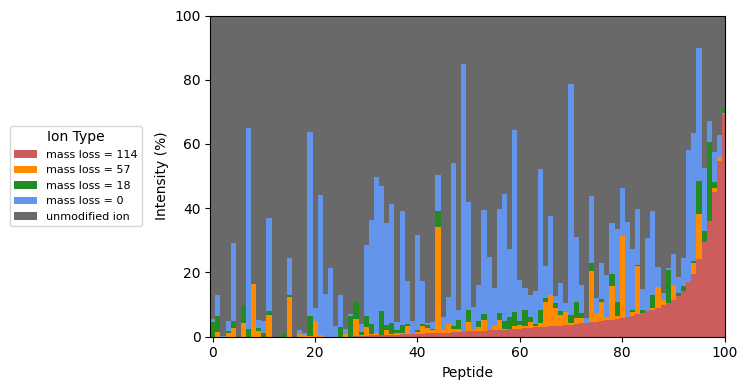

In [39]:
df = pd.DataFrame.from_dict(peptide_to_intensity, orient='index', columns=['unmodified', 'mass_loss_0', 'mass_loss_18', 'mass_loss_57', 'mass_loss_114'])

# Sort dataframe by -114 ion
df_sorted = df.sort_values(by='mass_loss_114')

# normalize intensities
df_normalized = df_sorted.div(df_sorted.sum(axis=1), axis=0) * 100

# Select every 58th peptide
plot_every_nth = 48
selected_peptides = df_normalized.iloc[::plot_every_nth]

num_peptides = len(selected_peptides)
bar_width = 1
colors = ['indianred', 'darkorange', 'forestgreen', 'cornflowerblue', 'dimgrey']

label_mapping = {
    'mass_loss_114': 'mass loss = 114',
    'mass_loss_57': 'mass loss = 57',
    'mass_loss_18': 'mass loss = 18',
    'mass_loss_0': 'mass loss = 0',
    'unmodified': 'unmodified ion'
}

fig, ax = plt.subplots(figsize=(8, 4))

for i, (idx, row_data) in enumerate(selected_peptides.iterrows()):
    bottom = 0
    for ion_type, color in zip(df.columns[::-1], colors):
        ax.bar(i, row_data[ion_type], bottom=bottom, width=bar_width, color=color, label=label_mapping[ion_type])
        bottom += row_data[ion_type]

ax.set_ylabel('Intensity (%)')
ax.set_xlabel('Peptide')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = ax.legend(by_label.keys(), title='Ion Type', loc='center left', bbox_to_anchor=(-0.4, 0.5), fontsize=8)
ax.set_xlim(-0.5, 100)
ax.set_xlim(-0.5,100)
ax.set_ylim(0,100)
fig.tight_layout()

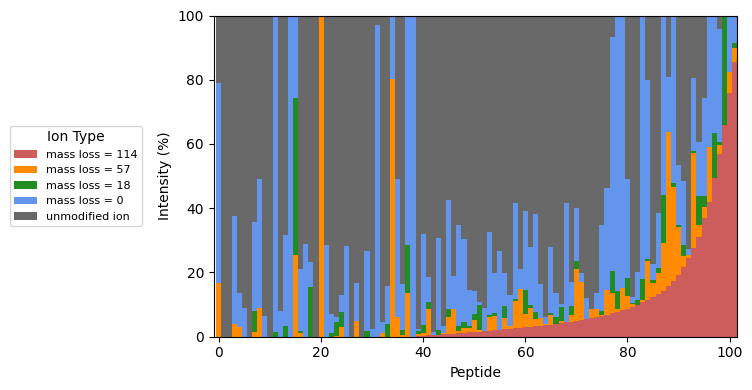

In [40]:
df = pd.DataFrame.from_dict(peptide_to_intensity_diff, orient='index', columns=['unmodified', 'mass_loss_0', 'mass_loss_18', 'mass_loss_57', 'mass_loss_114'])

# Sort dataframe by -114 ion
df_sorted = df.sort_values(by='mass_loss_114')

# normalize intensities
df_normalized = df_sorted.div(df_sorted.sum(axis=1), axis=0) * 100

# Select every 58th peptide
plot_every_nth = 46
selected_peptides = df_normalized.iloc[::plot_every_nth]

num_peptides = len(selected_peptides)
bar_width = 1
colors = ['indianred', 'darkorange', 'forestgreen', 'cornflowerblue', 'dimgrey']

label_mapping = {
    'mass_loss_114': 'mass loss = 114',
    'mass_loss_57': 'mass loss = 57',
    'mass_loss_18': 'mass loss = 18',
    'mass_loss_0': 'mass loss = 0',
    'unmodified': 'unmodified ion'
}

fig, ax = plt.subplots(figsize=(8, 4))

for i, (idx, row_data) in enumerate(selected_peptides.iterrows()):
    bottom = 0
    for ion_type, color in zip(df.columns[::-1], colors):
        ax.bar(i, row_data[ion_type], bottom=bottom, width=bar_width, color=color, label=label_mapping[ion_type])
        bottom += row_data[ion_type]

ax.set_ylabel('Intensity (%)')
ax.set_xlabel('Peptide')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = ax.legend(by_label.keys(), title='Ion Type', loc='center left', bbox_to_anchor=(-0.4, 0.5), fontsize=8)

ax.set_xlim(-1,101.5)
ax.set_ylim(0,100)
fig.tight_layout()

(0.0, 1.0)

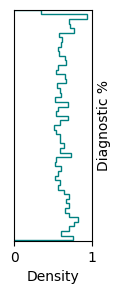

In [48]:
fig, ax = plt.subplots(figsize = (1,3))
ax.hist(diagnostic_intensity, bins=50, histtype='step', density=True, orientation='horizontal', color='teal')
ax.set_xticks([0, 1.6])
ax.set_xticklabels(['0', '1'])
ax.set_yticks([])
ax.set_xlabel('Density')
ax.set_ylabel('Diagnostic %')
ax.yaxis.set_label_position('right')
ax.set_ylim(0,1)

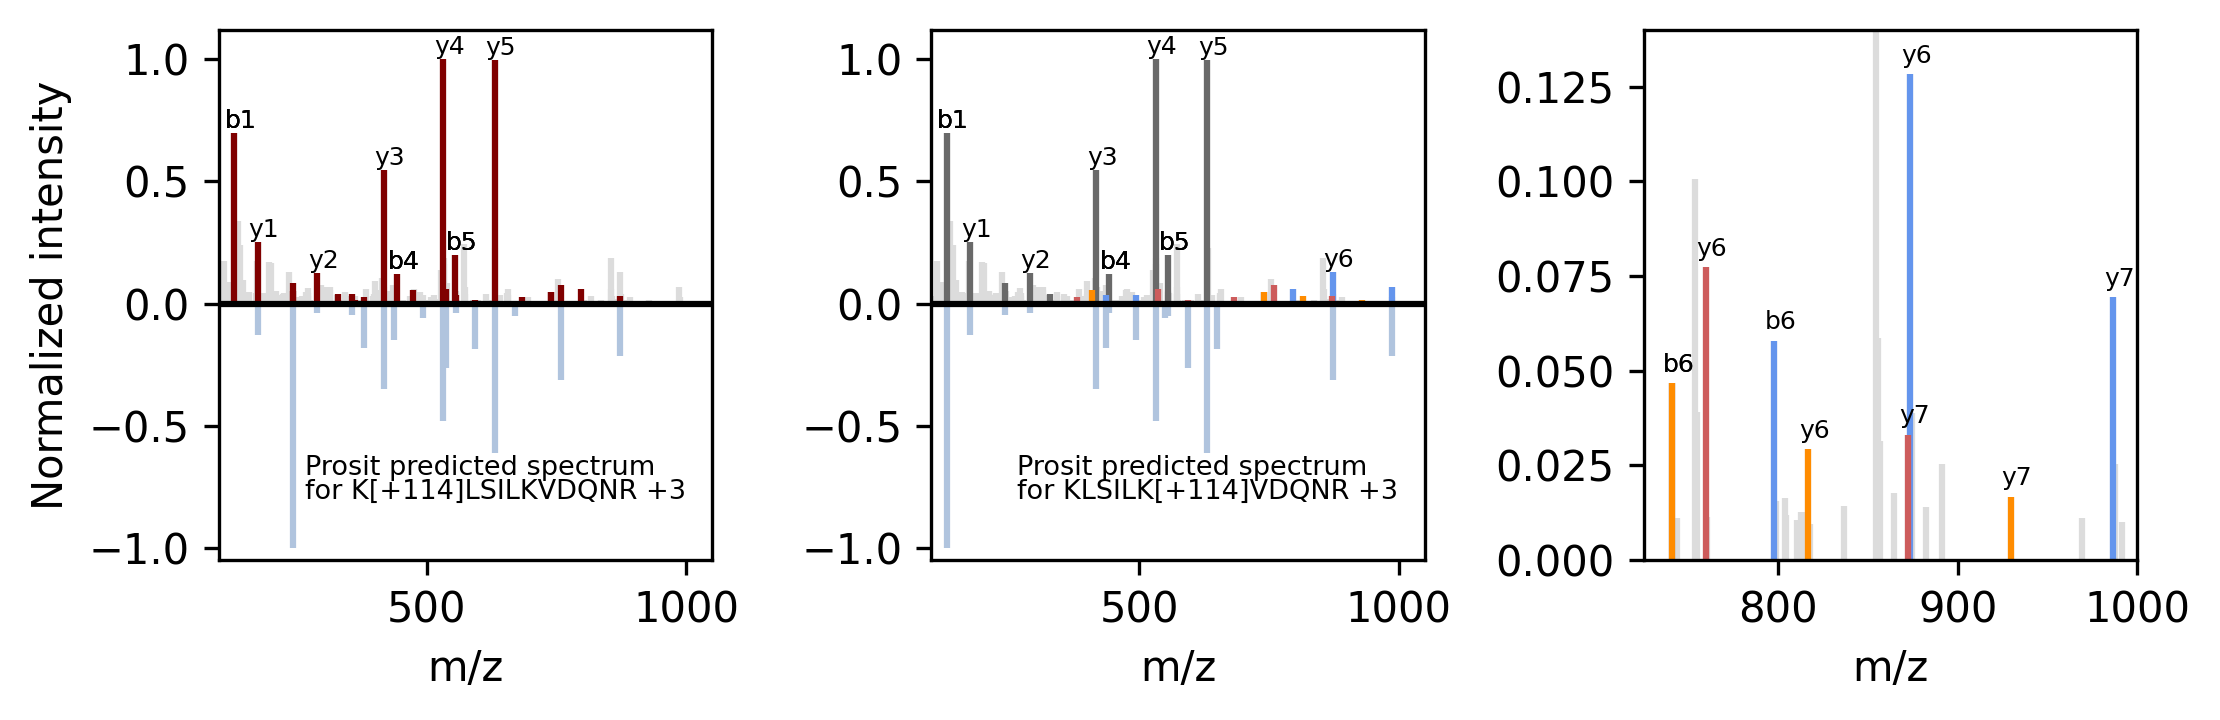

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5), dpi=300)
ax = axes[0]

mod_masses = [114.04292799999999, 57.021463999999995, 96.032363]
precursor = ('KLSILKVDQNR', 3)
mod_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
mod_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
mod_int = np.array(mod_int) / max(mod_int)
mz_to_int = dict(zip(mod_mz, mod_int))
frag_ion_df = annotate_ions_for_plotting(precursor[0], loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], precursor[1])

mod_mzs = []
for r in frag_ion_df.to_dict(orient='records'):
    if r['Mod'] == 1:
        ion_type, ion_charge = r['ion_type'], r['ion_charge']
        for mass in mod_masses:
            mz = r['ion_mz'] + mass / ion_charge
            mod_mzs.append({'ion_type': ion_type, 'Mod': 1, 'ion_mz': mz, 'ion_charge': ion_charge, 'mass_shift': mass})

mod_df = pd.DataFrame(mod_mzs)
total_frag_df = pd.concat([frag_ion_df, mod_df], ignore_index=True)

unmod_frags, mod_frags_114, mod_frags_96, mod_frags_57, mod_frags_0 = {}, {}, {}, {}, {}
text_list, x_list, y_list = [], [], []

for mz, intensity in mz_to_int.items():
    lower_lim, upper_lim = mz * (1 - 20e-6), mz * (1 + 20e-6)
    for r in total_frag_df.to_dict(orient='records'):
        if lower_lim < r['ion_mz'] < upper_lim:
            ion_type, mod, mass_shift = r['ion_type'], r['Mod'], r['mass_shift']
            if mod == 0:
                unmod_frags[mz] = intensity
                text_list.append(ion_type)
                x_list.append(mz)
                y_list.append(intensity)
            elif mod == 1:
                if mass_shift == 57.021463999999995:
                    mod_frags_57[mz] = intensity
                elif mass_shift == 96.032363:
                    mod_frags_96[mz] = intensity
                elif mass_shift == 114.04292799999999:
                    mod_frags_114[mz] = intensity
                else:
                    mod_frags_0[mz] = intensity
                text_list.append(ion_type)
                x_list.append(mz)
                y_list.append(intensity)

# plot experimental spectrum
ax.vlines(mod_mz, 0, mod_int, color = 'gainsboro')
ax.vlines(unmod_frags.keys(), 0, unmod_frags.values(), color='maroon', label='matched ions')
ax.vlines(mod_frags_114.keys(), 0, mod_frags_114.values(), color='maroon')
ax.vlines(mod_frags_96.keys(), 0, mod_frags_96.values(), color='maroon')
ax.vlines(mod_frags_57.keys(), 0, mod_frags_57.values(), color='maroon')
ax.vlines(mod_frags_0.keys(), 0, mod_frags_0.values(), color='maroon')
ax.set_xlim(100, 1050)
ax.set_ylim(-1.05, 1.12)
for i, text in enumerate(text_list):
    if y_list[i] > 0.1:
        ax.text(x_list[i] - 18, y_list[i] + 0.02, text, fontsize=6)
ax.set_xlabel('m/z')
ax.set_ylabel('Normalized intensity')

# plot predicted spectrum
prosit_mz = loaded_dict['trypsin']['Prosit']['modified'][precursor]['mz_array']
prosit_int = loaded_dict['trypsin']['Prosit']['modified'][precursor]['intensity_array']
frag_df = return_modified_frags(precursor[0], loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], precursor[1])

total_mz, total_int = [], []
for mz, intensity in zip(prosit_mz, prosit_int):
    if round(mz, 2) in frag_df:
        total_mz.append(frag_df[round(mz, 2)]['mod_ion_mz'])
        total_int.append(intensity)
    else:
        total_mz.append(mz)
        total_int.append(intensity)

ax.vlines(total_mz, 0, -1 * np.array(total_int), color='lightsteelblue')
ax.plot([0, 1300], [0, 0], color='k')
ax.text(265, -0.7, 'Prosit predicted spectrum', fontsize = 6.5)
ax.text(265, -0.8, 'for K[+114]LSILKVDQNR +3', fontsize = 6.5)
#legend = ax.legend(loc='upper right',fontsize=4)
ax = axes[1]
mod_masses = [114.04292799999999, 57.021463999999995, 96.032363]
peptide = precursor[0]
first_index = peptide.find('K')
second_index = peptide.find('K', first_index + 1)
mod_index = loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'].find('[+114.042927]')
if mod_index == first_index + 1:
    modseq = peptide[:second_index + 1] + '[+114.042927]' + peptide[second_index + 1:]
if mod_index == second_index + 1:
    modseq = peptide[:first_index + 1] + '[+114.042927]' + peptide[first_index + 1:]
mod_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
mod_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
mod_int = np.array(mod_int) / max(mod_int)
mz_to_int = dict(zip(mod_mz, mod_int))
frag_ion_df = annotate_ions_for_plotting(precursor[0], modseq, precursor[1])

mod_mzs = []
for r in frag_ion_df.to_dict(orient='records'):
    if r['Mod'] == 1:
        ion_type, ion_charge = r['ion_type'], r['ion_charge']
        for mass in mod_masses:
            mz = r['ion_mz'] + mass / ion_charge
            mod_mzs.append({'ion_type': ion_type, 'Mod': 1, 'ion_mz': mz, 'ion_charge': ion_charge, 'mass_shift': mass})

mod_df = pd.DataFrame(mod_mzs)
total_frag_df = pd.concat([frag_ion_df, mod_df], ignore_index=True)

unmod_frags, mod_frags_114, mod_frags_96, mod_frags_57, mod_frags_0 = {}, {}, {}, {}, {}
text_list, x_list, y_list = [], [], []

for mz, intensity in mz_to_int.items():
    lower_lim, upper_lim = mz * (1 - 20e-6), mz * (1 + 20e-6)
    for r in total_frag_df.to_dict(orient='records'):
        if lower_lim < r['ion_mz'] < upper_lim:
            ion_type, mod, mass_shift = r['ion_type'], r['Mod'], r['mass_shift']
            if mod == 0:
                unmod_frags[mz] = intensity
                text_list.append(ion_type)
                x_list.append(mz)
                y_list.append(intensity)
            elif mod == 1:
                if mass_shift == 57.021463999999995:
                    mod_frags_57[mz] = intensity
                elif mass_shift == 96.032363:
                    mod_frags_96[mz] = intensity
                elif mass_shift == 114.04292799999999:
                    mod_frags_114[mz] = intensity
                else:
                    mod_frags_0[mz] = intensity
                text_list.append(ion_type)
                x_list.append(mz)
                y_list.append(intensity)

# plot experimental spectrum
ax.vlines(mod_mz, 0, mod_int, color = 'gainsboro')
ax.vlines(unmod_frags.keys(), 0, unmod_frags.values(), color='dimgrey', label='unmodified ion')
ax.vlines(mod_frags_114.keys(), 0, mod_frags_114.values(), color='cornflowerblue', label='mass loss = 0')
ax.vlines(mod_frags_96.keys(), 0, mod_frags_96.values(), color='forestgreen', label='mass loss = 18')
ax.vlines(mod_frags_57.keys(), 0, mod_frags_57.values(), color='darkorange', label='mass loss = 57')
ax.vlines(mod_frags_0.keys(), 0, mod_frags_0.values(), color='indianred', label='mass loss = 114')
ax.set_xlim(100, 1050)
ax.set_ylim(-1.05, 1.12)

for i, text in enumerate(text_list):
    if y_list[i] > 0.1:
        ax.text(x_list[i] - 18, y_list[i] + 0.02, text, fontsize=6)
ax.set_xlabel('m/z')

# plot predicted spectrum
prosit_mz = loaded_dict['trypsin']['Prosit']['modified'][precursor]['mz_array']
prosit_int = loaded_dict['trypsin']['Prosit']['modified'][precursor]['intensity_array']
frag_df = return_modified_frags(precursor[0], modseq, precursor[1])


total_mz, total_int = [], []
for mz, intensity in zip(prosit_mz, prosit_int):
    if round(mz, 2) in frag_df:
        total_mz.append(frag_df[round(mz, 2)]['mod_ion_mz'])
        total_int.append(intensity)
    else:
        total_mz.append(mz)
        total_int.append(intensity)

ax.vlines(total_mz, 0, -1 * np.array(total_int), color='lightsteelblue')
ax.plot([0, 1300], [0, 0], color='k')
ax.text(265, -0.7, 'Prosit predicted spectrum', fontsize = 6.5)
ax.text(265, -0.8, 'for KLSILK[+114]VDQNR +3', fontsize = 6.5)


ax = axes[2]
ax.vlines(mod_mz, 0, mod_int, color = 'gainsboro')
ax.vlines(unmod_frags.keys(), 0, unmod_frags.values(), color='dimgrey', label='unmodified ion')
ax.vlines(mod_frags_114.keys(), 0, mod_frags_114.values(), color='cornflowerblue', label='mass loss = 0')
ax.vlines(mod_frags_96.keys(), 0, mod_frags_96.values(), color='forestgreen', label='mass loss = 18')
ax.vlines(mod_frags_57.keys(), 0, mod_frags_57.values(), color='darkorange', label='mass loss = 57')
ax.vlines(mod_frags_0.keys(), 0, mod_frags_0.values(), color='indianred', label='mass loss = 114')
ax.set_xlim(725, 1000)
ax.set_ylim(0, 0.14)
ax.set_xlabel('m/z')
for i, text in enumerate(text_list):
    if 700 < x_list[i] < 1000:
        ax.text(x_list[i] - 5, y_list[i] + 0.003, text, fontsize=6)
        


fig.tight_layout()

In [53]:
# score at different locations
msfragger_loc_scores = []
other_loc_scores = []

for precursor in missed_cleavage_precursors:
    
    if precursor in loaded_dict['trypsin']['Prosit']['modified'].keys():
        exp_mz = loaded_dict['trypsin']['experimental']['modified'][precursor]['mz_array']
        exp_int = loaded_dict['trypsin']['experimental']['modified'][precursor]['intensity_array']
        prosit_mz = loaded_dict['trypsin']['Prosit']['modified'][precursor]['mz_array']
        prosit_int = loaded_dict['trypsin']['Prosit']['modified'][precursor]['intensity_array']

        # mass correct modified fragment ions
        frag_df = return_modified_frags(precursor[0], loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], precursor[1])

        total_mz, total_int = zip(*[
            (frag_df[round(mz, 2)]['mod_ion_mz'] if round(mz, 2) in frag_df else mz, prosit_int[index])
            for index, mz in enumerate(prosit_mz)
        ])
        
        score1, exp_mz, exp_int, prosit_mz, prosit_int = cosine_similarity(exp_mz, exp_int, total_mz, total_int, loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'], softmax = True)
    
        msfragger_loc_scores.append(score1)
        
        peptide = precursor[0]
        first_index = peptide.find('K')
        second_index = peptide.find('K', first_index + 1)
        mod_index = loaded_dict['trypsin']['experimental']['modified'][precursor]['ModSeq'].find('[+114.042927]')
        if mod_index == first_index + 1:
            modseq = peptide[:second_index + 1] + '[+114.042927]' + peptide[second_index + 1:]
        if mod_index == second_index + 1:
            modseq = peptide[:first_index + 1] + '[+114.042927]' + peptide[first_index + 1:]
            
         # mass correct modified fragment ions
        frag_df = return_modified_frags(precursor[0], modseq, precursor[1])

        total_mz, total_int = zip(*[
            (frag_df[round(mz, 2)]['mod_ion_mz'] if round(mz, 2) in frag_df else mz, prosit_int[index])
            for index, mz in enumerate(prosit_mz)
        ])
        
        score2, exp_mz, exp_int, prosit_mz, prosit_int = cosine_similarity(exp_mz, exp_int, total_mz, total_int, modseq, softmax = True)
        
        other_loc_scores.append(score2)

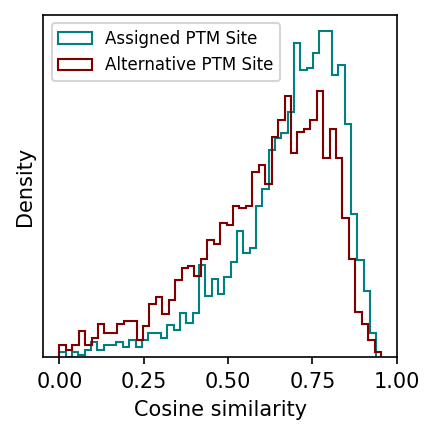

In [55]:
array_of_scores_score_comparison = [np.array(unmod_scores),np.array(mod_scores)]
fig, ax = plt.subplots(dpi = 150, figsize = (3, 3))
#label1 = 'Unmodified (n = '+str(len(array_of_scores_score_comparison[0]))+')'
#label2 = 'Modified (n = '+str(len(array_of_scores_score_comparison[1]))+')'
ax.hist(msfragger_loc_scores, color = 'teal',bins=50,histtype='step', density=True, label = 'Assigned PTM Site')
ax.hist(other_loc_scores,color = 'maroon',bins=50,histtype='step', density=True, label = 'Alternative PTM Site')
ax.set_xlabel('Cosine similarity')
ax.set_ylabel('Density')
legend = ax.legend(loc='upper left',fontsize=8)
ax.set_yticks([])
fig.tight_layout()